In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
experiment = 'CNN Time Series Experiments - noncyclic'

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa
import glob
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
import math

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Performance Metrics Functions

In [5]:
def pred_acc(actual, predictions, logger):

    hold = 0
    sell = 0
    buy = 0
    pred_hold = 0
    pred_sell = 0
    pred_buy = 0
    buy_buy = 0
    buy_sell = 0
    buy_hold = 0
    sell_buy = 0
    sell_sell = 0
    sell_hold = 0
    hold_buy = 0
    hold_sell = 0
    hold_hold = 0

    for i in range (0,len(actual)):
        if actual[i]==1 and predictions[i] == 1:
            buy_buy += 1
            buy += 1
            pred_buy += 1
        elif actual[i]==1 and predictions[i] == 0:
            buy_sell += 1
            buy += 1
            pred_sell += 1
        elif actual[i]==1 and predictions[i] == 2:
            buy_hold += 1
            buy += 1
            pred_hold += 1
        elif actual[i]==0 and predictions[i] == 1:
            sell_buy += 1
            sell += 1
            pred_buy += 1
        elif actual[i]==0 and predictions[i] == 0:
            sell_sell += 1
            sell += 1
            pred_sell += 1
        elif actual[i]==0 and predictions[i] == 2:
            sell_hold += 1
            sell += 1
            pred_hold += 1
        elif actual[i]==2 and predictions[i] == 1:
            hold_buy += 1
            hold += 1
            pred_buy += 1
        elif actual[i]==2 and predictions[i] == 0:
            hold_sell += 1
            hold += 1
            pred_sell += 1
        elif actual[i]==2 and predictions[i] == 2:
            hold_hold += 1
            hold += 1
            pred_hold += 1

    print("number of predictions: " + str(len(actual)))
    print("actual predicted buys: " + str(buy_buy) )
    print("actual buys but predicted sell: " + str(buy_sell) )
    print("actual buys but predicted hold: " + str(buy_hold))
    print("actual sells but predicted buy: " + str(sell_buy) )
    print("actual predicted sells: " + str(sell_sell))
    print("actual sells but predicted hold: " + str(sell_hold) )
    print("actual holds but predicted buy: " + str(hold_buy) )
    print("actual holds but predicted sell: " + str(hold_sell))
    print("actual predicted holds: " + str(hold_hold) )
    
    if pred_buy !=0:
        Percentage_buys_correct = 100*buy_buy/pred_buy
    else:
        Percentage_buys_correct = 0
        
    if pred_sell !=0:
        Percentage_sells_correct = 100*sell_sell/pred_sell
    else:
        Percentage_sells_correct = 0
        
    if pred_hold !=0:
        Percentage_holds_correct = 100*hold_hold/pred_hold
    else:
        Percentage_holds_correct = 0

    print("Percentage buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage holds correct: " + str(Percentage_holds_correct) + "%")

    print("actual buys: " + str(buy))
    print("actual sells: " + str(sell))
    print("actual holds: " + str(hold))
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger


In [6]:
def correct_maxima_minima(predictions, price, logger):
    correct_maxima = 0 
    correct_minima = 0
    correct_hold = 0

    hold = 0
    buy = 0
    sell = 0

#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):
        if i < 4:
            prices = price[i:i+9]
            prices.sort(key = float)
#             if i == 0:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1

        else:
            prices = price[i:i+5]
            prices = prices + price[i-4:i] 
            prices.sort(key = float)
#             if i == 10:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1
                    
    if buy !=0:
        Percentage_buys_correct = 100*correct_minima/buy
    else:
        Percentage_buys_correct = 0
        
    if sell !=0:
        Percentage_sells_correct = 100*correct_maxima/sell
    else:
        Percentage_sells_correct = 0
        
    if hold !=0:
        Percentage_holds_correct = 100*correct_hold/hold
    else:
        Percentage_holds_correct = 0

    print("Percentage low buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage high sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage mid holds correct: " + str(Percentage_holds_correct) + "%")
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger

In [7]:
def profit(predictions, price, logger):
    
    price = np.array([price]).reshape(-1, 1)
    min_max_scaler = preprocessing.MinMaxScaler()
    price = min_max_scaler.fit_transform(price)
    price = price.flatten().tolist()
    price = [x + 0.01 for x in price]
    
#     avg_price = sum(price) / len(price)
#     avg_price = int(avg_price)
#     print("Avg price of stocks: " + str(avg_price))
    
#     tens = 1
#     while avg_price >= 10:
#         avg_price /= 10
#         tens += 1
    
    
#     capital = 100*pow(10,tens-1)
    capital = 100
    print("Capital: " + str(capital))
    shares = 0

    previously_buy = False
    previously_sell = False
    prev_buy_price = 0
    bought_once = False


#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):

#         if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 5 and shares!=0:
#             capital += 0.99725 * (shares*price[i])
#             shares = 0
#             print("Stop Loss Activated!\n")
#             print("Share price: $" + str(price[i]))
#             print("Shares owned at the moment: " + str(shares))
#             print("Cash capital at the moment: $" + str(capital))
#             print("\n")
#             previously_buy = False
#             previously_sell = True

        if predictions[i] == 1 and previously_buy != True:
            shares = math.floor(capital / (price[i]*1.00275))
            capital = capital - shares*price[i]*1.00275
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            prev_buy_price = price[i]*1.00275
            bought_once = True
            previously_buy = True
            previously_sell = False

        elif predictions[i] == 0 and previously_sell != True and shares!=0: #and (price[i]/prev_buy_price-1)*100 >= 2
            capital += 0.99725 * (shares*price[i])
            shares = 0
            print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            previously_buy = False
            previously_sell = True

    if shares!=0:
        capital += 0.99725 * (shares*price[i])

    print('\n')
    print("Capital at the end of test period: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100)
    
    capital = 100
    shares = 0

    shares = math.floor(capital / (price[0]*1.00275))
    capital = capital - shares*price[0]*1.00275
    capital += 0.99725 * (shares*price[-1])

    print('\n')
    print("Capital at the end of test period if Buy and Hold: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100 )
    
    return logger

## noncyclic Stocks

### Kweichow Moutai Co., Ltd.

In [8]:
nr_test_sets = ['600519.SS']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_15 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1
    seq_new = []
    data_15 = []
    for i in range(0,len(sequential)):
        for j in range(0,len(sequential[i])):
            x = sequential[i][j]
            a = np.zeros(60)
            data_15.append(np.concatenate((x, a)))

        for j in range(1,50):
            x = np.zeros(64)
            data_15.append(x)
        seq_new.append(data_15)
        data_15 = []
        
    X = np.array(seq_new).reshape(-1, 64, 64, 1)
    y = labels
    y = np.array(y)
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2019-01-22   686.979980  640.790403 -10.183147  35030093.0     2.0
2019-01-23   671.000000  645.438034 -23.857615  30817872.0     2.0
2019-01-24   665.659973  648.549101 -28.427209  27455391.0     2.0
2019-01-25   672.500000  652.233855 -26.754575  30370918.0     2.0
2019-01-28   679.700012  656.459418 -19.452330  33269553.0     2.0


In [9]:
r_test_sets = ['600519.SS']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_15 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1
    seq_new = []
    data_15 = []
    for i in range(0,len(sequential)):
        for j in range(0,len(sequential[i])):
            x = sequential[i][j]
            a = np.zeros(60)
            data_15.append(np.concatenate((x, a)))

        for j in range(1,50):
            x = np.zeros(64)
            data_15.append(x)
        seq_new.append(data_15)
        data_15 = []
        
    X = np.array(seq_new).reshape(-1, 64, 64, 1)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d       EMA_12   willr_14       OBV_7  labels
Date                                                               
2020-01-22  1075.300049  1097.577291 -89.711935   1200864.0     2.0
2020-01-23  1075.510010  1094.182325 -70.779503   4820868.0     2.0
2020-02-03  1052.800049  1087.815821 -81.895216   -525975.0     1.0
2020-02-04  1003.919983  1074.908769 -83.419991 -12870263.0     2.0
2020-02-05  1038.010010  1069.232037 -59.790669  -6607845.0     2.0


### Creating Training Data and Model

            previous_1d    EMA_12   willr_14        OBV_7  labels
Date                                                             
2001-09-14     7.142585  7.257483 -41.873824  204624213.0     2.0
2001-09-17     7.224180  7.252359 -51.296847  208479649.0     2.0
2001-09-18     7.132634  7.233940 -72.964156  203965392.0     2.0
2001-09-19     7.214230  7.230908 -59.609037  209378730.0     2.0
2001-09-20     7.347568  7.248855 -37.785092  213725440.0     2.0


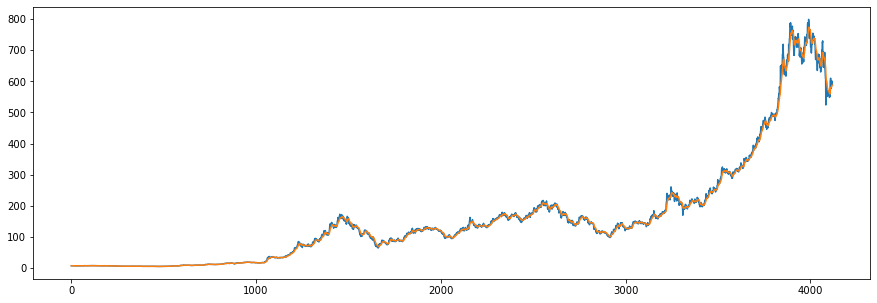

In [10]:
seed = 10
df = pd.read_csv('data/noncyclic_tickers/initial_indicators/600519.SS_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
seq_new = []
data_15 = []
for i in range(0,len(sequential)):
    for j in range(0,len(sequential[i])):
        x = sequential[i][j]
        a = np.zeros(60)
        data_15.append(np.concatenate((x, a)))
        
    for j in range(1,50):
        x = np.zeros(64)
        data_15.append(x)
    seq_new.append(data_15)
    data_15 = []
    
X = np.array(seq_new).reshape(-1, 64, 64, 1)
y = labels
y = np.array(y)

In [11]:
from collections import Counter

Counter(y)

Counter({2.0: 3738, 1.0: 183, 0.0: 185})

In [12]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [13]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [14]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [16]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('600519.SS')]
    y = nr_test_data['{}_y'.format('600519.SS')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format('600519.SS'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_non_recession.csv'.format(experiment,'600519.SS')):
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'600519.SS'))
    else:
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'600519.SS'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('600519.SS')]
    y = r_test_data['{}_y'.format('600519.SS')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test2.csv".format('600519.SS'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_recession.csv'.format(experiment,'600519.SS')):
        log.to_csv('{}_{}_recession.csv'.format(experiment,'600519.SS'))
    else:
        log.to_csv('{}_{}_recession.csv'.format(experiment,'600519.SS'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.396396396396397, 1: 7.497716894977169, 2: 0.3661092530657748}



RUNNING EPOCHS 0 - 20



Epoch 1/20
26/26 [==============================] - 1s 24ms/step - loss: 0.2222 - accuracy: 0.3608 - mse: 0.9236 - weighted_accuracy: 0.2989 - weighted_mse: 0.9553 - val_loss: 0.1890 - val_accuracy: 0.2299 - val_mse: 1.1472 - val_weighted_accuracy: 0.2299 - val_weighted_mse: 1.1472
Epoch 2/20
26/26 [==============================] - 0s 12ms/step - loss: 0.2033 - accuracy: 0.3971 - mse: 1.1622 - weighted_accuracy: 0.3503 - weighted_mse: 1.1791 - val_loss: 0.1865 - val_accuracy: 0.5839 - val_mse: 1.0446 - val_weighted_accuracy: 0.5839 - val_weighted_mse: 1.0446
Epoch 3/20
26/26 [==============================] - 0s 12ms/step - loss: 0.1994 - accuracy: 0.3715 - mse: 1.1402 - weighted_accuracy: 0.3943 - weighted_mse: 1.1572 - val_loss: 0.1850 - val_accuracy: 0.4148 - val_mse: 1.1377 - val_weighted_accuracy: 0.4148 - val_weighted_mse: 1.1377
Epoch 4/20
26/26 [==============================] - 0s 

0        1666.892281  


Recession Test


7/7 [==============================] - 0s 8ms/step - loss: 0.2009 - accuracy: 0.1683 - mse: 1.2755 - weighted_accuracy: 0.1683 - weighted_mse: 1.2755
Test loss: 0.2008761763572693
Test accuracy: 0.16826923191547394


number of predictions: 208
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 9
actual sells but predicted hold: 0
actual holds but predicted buy: 53
actual holds but predicted sell: 117
actual predicted holds: 19
Percentage buys correct: 11.475409836065573%
Percentage sells correct: 7.086614173228346%
Percentage holds correct: 95.0%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 55.73770491803279%
Percentage high sells correct: 48.41269841269841%
Percentage mid holds correct: 75.0%


Capital: 100
Share price: $0.09936061724328947
Shares owned at the moment: 1003
Cash capital at the moment: $0.067239

Epoch 13/20
26/26 [==============================] - 0s 14ms/step - loss: 0.1665 - accuracy: 0.2628 - mse: 1.4871 - weighted_accuracy: 0.5946 - weighted_mse: 1.3782 - val_loss: 0.1991 - val_accuracy: 0.2019 - val_mse: 1.3788 - val_weighted_accuracy: 0.2019 - val_weighted_mse: 1.3788
Epoch 14/20
26/26 [==============================] - 0s 14ms/step - loss: 0.1637 - accuracy: 0.2132 - mse: 1.4950 - weighted_accuracy: 0.5850 - weighted_mse: 1.3961 - val_loss: 0.2084 - val_accuracy: 0.1436 - val_mse: 1.4558 - val_weighted_accuracy: 0.1436 - val_weighted_mse: 1.4558
Epoch 15/20
26/26 [==============================] - 0s 14ms/step - loss: 0.1648 - accuracy: 0.2302 - mse: 1.5117 - weighted_accuracy: 0.5762 - weighted_mse: 1.4168 - val_loss: 0.1994 - val_accuracy: 0.1861 - val_mse: 1.3937 - val_weighted_accuracy: 0.1861 - val_weighted_mse: 1.3937
Epoch 16/20
26/26 [==============================] - 0s 15ms/step - loss: 0.1666 - accuracy: 0.2329 - mse: 1.5066 - weighted_accuracy: 0.5621 - weig

7/7 [==============================] - 0s 3ms/step - loss: 0.2070 - accuracy: 0.1683 - mse: 1.3704 - weighted_accuracy: 0.1683 - weighted_mse: 1.3704
Test loss: 0.20696261525154114
Test accuracy: 0.16826923191547394


number of predictions: 208
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 9
actual sells but predicted hold: 0
actual holds but predicted buy: 54
actual holds but predicted sell: 116
actual predicted holds: 19
Percentage buys correct: 11.290322580645162%
Percentage sells correct: 7.142857142857143%
Percentage holds correct: 95.0%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 58.064516129032256%
Percentage high sells correct: 49.6%
Percentage mid holds correct: 90.0%


Capital: 100
Share price: $0.09936061724328947
Shares owned at the moment: 1003
Cash capital at the moment: $0.06723948246934697


Price increase from previously bought: 

Epoch 9/20
26/26 [==============================] - 0s 13ms/step - loss: 0.1576 - accuracy: 0.2710 - mse: 1.6092 - weighted_accuracy: 0.6233 - weighted_mse: 1.5014 - val_loss: 0.1918 - val_accuracy: 0.2397 - val_mse: 1.5045 - val_weighted_accuracy: 0.2397 - val_weighted_mse: 1.5045
Epoch 10/20
26/26 [==============================] - 0s 14ms/step - loss: 0.1608 - accuracy: 0.2570 - mse: 1.5750 - weighted_accuracy: 0.5752 - weighted_mse: 1.4828 - val_loss: 0.2009 - val_accuracy: 0.1813 - val_mse: 1.5253 - val_weighted_accuracy: 0.1813 - val_weighted_mse: 1.5253
Epoch 11/20
26/26 [==============================] - 0s 13ms/step - loss: 0.1578 - accuracy: 0.2445 - mse: 1.6380 - weighted_accuracy: 0.5921 - weighted_mse: 1.5454 - val_loss: 0.1975 - val_accuracy: 0.2263 - val_mse: 1.4656 - val_weighted_accuracy: 0.2263 - val_weighted_mse: 1.4656
Epoch 12/20
26/26 [==============================] - 0s 13ms/step - loss: 0.1542 - accuracy: 0.2938 - mse: 1.6350 - weighted_accuracy: 0.6468 - weigh

7/7 [==============================] - 0s 3ms/step - loss: 0.2026 - accuracy: 0.2308 - mse: 1.5226 - weighted_accuracy: 0.2308 - weighted_mse: 1.5226
Test loss: 0.20258250832557678
Test accuracy: 0.23076923191547394


number of predictions: 208
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 9
actual sells but predicted hold: 0
actual holds but predicted buy: 47
actual holds but predicted sell: 110
actual predicted holds: 32
Percentage buys correct: 12.727272727272727%
Percentage sells correct: 7.5%
Percentage holds correct: 96.96969696969697%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 56.36363636363637%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 90.625%


Capital: 100
Share price: $0.09936061724328947
Shares owned at the moment: 1003
Cash capital at the moment: $0.06723948246934697


Price increase from previously bought: 

Epoch 10/20
26/26 [==============================] - 0s 12ms/step - loss: 0.1527 - accuracy: 0.2652 - mse: 1.6923 - weighted_accuracy: 0.6255 - weighted_mse: 1.6188 - val_loss: 0.2001 - val_accuracy: 0.2202 - val_mse: 1.6065 - val_weighted_accuracy: 0.2202 - val_weighted_mse: 1.6065
Epoch 11/20
26/26 [==============================] - 0s 13ms/step - loss: 0.1499 - accuracy: 0.2646 - mse: 1.7240 - weighted_accuracy: 0.6405 - weighted_mse: 1.6501 - val_loss: 0.1978 - val_accuracy: 0.2311 - val_mse: 1.6130 - val_weighted_accuracy: 0.2311 - val_weighted_mse: 1.6130
Epoch 12/20
26/26 [==============================] - 0s 13ms/step - loss: 0.1487 - accuracy: 0.3002 - mse: 1.7357 - weighted_accuracy: 0.6535 - weighted_mse: 1.6708 - val_loss: 0.2012 - val_accuracy: 0.2044 - val_mse: 1.6834 - val_weighted_accuracy: 0.2044 - val_weighted_mse: 1.6834
Epoch 13/20
26/26 [==============================] - 0s 13ms/step - loss: 0.1487 - accuracy: 0.2890 - mse: 1.7186 - weighted_accuracy: 0.6257 - weig

7/7 [==============================] - 0s 3ms/step - loss: 0.2069 - accuracy: 0.2356 - mse: 1.7745 - weighted_accuracy: 0.2356 - weighted_mse: 1.7745
Test loss: 0.20694874227046967
Test accuracy: 0.23557692766189575


number of predictions: 208
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 9
actual sells but predicted hold: 0
actual holds but predicted buy: 45
actual holds but predicted sell: 111
actual predicted holds: 33
Percentage buys correct: 13.20754716981132%
Percentage sells correct: 7.43801652892562%
Percentage holds correct: 97.05882352941177%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 58.490566037735846%
Percentage high sells correct: 49.586776859504134%
Percentage mid holds correct: 93.93939393939394%


Capital: 100
Share price: $0.09936061724328947
Shares owned at the moment: 1003
Cash capital at the moment: $0.06723948246934697


P

Epoch 11/20
26/26 [==============================] - 0s 13ms/step - loss: 0.1448 - accuracy: 0.3182 - mse: 1.8641 - weighted_accuracy: 0.6643 - weighted_mse: 1.7764 - val_loss: 0.1936 - val_accuracy: 0.2652 - val_mse: 1.7804 - val_weighted_accuracy: 0.2652 - val_weighted_mse: 1.7804
Epoch 12/20
26/26 [==============================] - 0s 13ms/step - loss: 0.1474 - accuracy: 0.3076 - mse: 1.7949 - weighted_accuracy: 0.6497 - weighted_mse: 1.7127 - val_loss: 0.2036 - val_accuracy: 0.2129 - val_mse: 1.7789 - val_weighted_accuracy: 0.2129 - val_weighted_mse: 1.7789
Epoch 13/20
26/26 [==============================] - 0s 12ms/step - loss: 0.1453 - accuracy: 0.3079 - mse: 1.8418 - weighted_accuracy: 0.6778 - weighted_mse: 1.7471 - val_loss: 0.1989 - val_accuracy: 0.2372 - val_mse: 1.8319 - val_weighted_accuracy: 0.2372 - val_weighted_mse: 1.8319
Epoch 14/20
26/26 [==============================] - 0s 12ms/step - loss: 0.1437 - accuracy: 0.2859 - mse: 1.9209 - weighted_accuracy: 0.6697 - weig



Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.2086 - accuracy: 0.2500 - mse: 1.9328 - weighted_accuracy: 0.2500 - weighted_mse: 1.9328
Test loss: 0.20858143270015717
Test accuracy: 0.25


number of predictions: 208
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 9
actual sells but predicted hold: 0
actual holds but predicted buy: 42
actual holds but predicted sell: 111
actual predicted holds: 36
Percentage buys correct: 14.0%
Percentage sells correct: 7.43801652892562%
Percentage holds correct: 97.29729729729729%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 60.0%
Percentage high sells correct: 49.586776859504134%
Percentage mid holds correct: 91.66666666666667%


Capital: 100
Share price: $0.09936061724328947
Shares owned at the moment: 1003
Cash capital at the moment: $0.06723948246934697


Price increase from prev

Epoch 11/20
26/26 [==============================] - 0s 12ms/step - loss: 0.1400 - accuracy: 0.3420 - mse: 2.0087 - weighted_accuracy: 0.6945 - weighted_mse: 1.9132 - val_loss: 0.1970 - val_accuracy: 0.2567 - val_mse: 1.8279 - val_weighted_accuracy: 0.2567 - val_weighted_mse: 1.8279
Epoch 12/20
26/26 [==============================] - 0s 13ms/step - loss: 0.1394 - accuracy: 0.3356 - mse: 1.9925 - weighted_accuracy: 0.6878 - weighted_mse: 1.9234 - val_loss: 0.1977 - val_accuracy: 0.2749 - val_mse: 1.9769 - val_weighted_accuracy: 0.2749 - val_weighted_mse: 1.9769
Epoch 13/20
26/26 [==============================] - 0s 12ms/step - loss: 0.1380 - accuracy: 0.3599 - mse: 1.9894 - weighted_accuracy: 0.6839 - weighted_mse: 1.9687 - val_loss: 0.2001 - val_accuracy: 0.2640 - val_mse: 1.9031 - val_weighted_accuracy: 0.2640 - val_weighted_mse: 1.9031
Epoch 14/20
26/26 [==============================] - 0s 12ms/step - loss: 0.1378 - accuracy: 0.3194 - mse: 2.0450 - weighted_accuracy: 0.6971 - weig

7/7 [==============================] - 0s 2ms/step - loss: 0.2097 - accuracy: 0.2885 - mse: 2.1866 - weighted_accuracy: 0.2885 - weighted_mse: 2.1866
Test loss: 0.2097245156764984
Test accuracy: 0.2884615361690521


number of predictions: 208
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 9
actual sells but predicted hold: 0
actual holds but predicted buy: 32
actual holds but predicted sell: 113
actual predicted holds: 44
Percentage buys correct: 17.5%
Percentage sells correct: 7.317073170731708%
Percentage holds correct: 97.77777777777777%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 62.5%
Percentage high sells correct: 49.18032786885246%
Percentage mid holds correct: 93.33333333333333%


Capital: 100
Share price: $0.09936061724328947
Shares owned at the moment: 1003
Cash capital at the moment: $0.06723948246934697


Price increase from previously

Epoch 12/20
26/26 [==============================] - 0s 12ms/step - loss: 0.1330 - accuracy: 0.3642 - mse: 2.1281 - weighted_accuracy: 0.7091 - weighted_mse: 2.0900 - val_loss: 0.1948 - val_accuracy: 0.3090 - val_mse: 2.0842 - val_weighted_accuracy: 0.3090 - val_weighted_mse: 2.0842
Epoch 13/20
26/26 [==============================] - 0s 14ms/step - loss: 0.1334 - accuracy: 0.3974 - mse: 2.1196 - weighted_accuracy: 0.7148 - weighted_mse: 2.1132 - val_loss: 0.2019 - val_accuracy: 0.2835 - val_mse: 2.0467 - val_weighted_accuracy: 0.2835 - val_weighted_mse: 2.0467
Epoch 14/20
26/26 [==============================] - 0s 16ms/step - loss: 0.1346 - accuracy: 0.3502 - mse: 2.1369 - weighted_accuracy: 0.7083 - weighted_mse: 2.0813 - val_loss: 0.2004 - val_accuracy: 0.2762 - val_mse: 2.0665 - val_weighted_accuracy: 0.2762 - val_weighted_mse: 2.0665
Epoch 15/20
26/26 [==============================] - 0s 16ms/step - loss: 0.1317 - accuracy: 0.3669 - mse: 2.1347 - weighted_accuracy: 0.7165 - weig

7/7 [==============================] - 0s 4ms/step - loss: 0.2135 - accuracy: 0.2885 - mse: 2.2376 - weighted_accuracy: 0.2885 - weighted_mse: 2.2376
Test loss: 0.21354183554649353
Test accuracy: 0.2884615361690521


number of predictions: 208
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 9
actual sells but predicted hold: 0
actual holds but predicted buy: 39
actual holds but predicted sell: 106
actual predicted holds: 44
Percentage buys correct: 14.893617021276595%
Percentage sells correct: 7.758620689655173%
Percentage holds correct: 97.77777777777777%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 61.702127659574465%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 93.18181818181819%


Capital: 100
Share price: $0.09936061724328947
Shares owned at the moment: 1003
Cash capital at the moment: $0.06723948246934697


Price increase

Epoch 11/20
26/26 [==============================] - 0s 12ms/step - loss: 0.1300 - accuracy: 0.3925 - mse: 2.2441 - weighted_accuracy: 0.7302 - weighted_mse: 2.2451 - val_loss: 0.1856 - val_accuracy: 0.3674 - val_mse: 2.1095 - val_weighted_accuracy: 0.3674 - val_weighted_mse: 2.1095
Epoch 12/20
26/26 [==============================] - 0s 12ms/step - loss: 0.1253 - accuracy: 0.4096 - mse: 2.2495 - weighted_accuracy: 0.7366 - weighted_mse: 2.3282 - val_loss: 0.1918 - val_accuracy: 0.3516 - val_mse: 2.1990 - val_weighted_accuracy: 0.3516 - val_weighted_mse: 2.1990
Epoch 13/20
26/26 [==============================] - 0s 12ms/step - loss: 0.1281 - accuracy: 0.4482 - mse: 2.2658 - weighted_accuracy: 0.7420 - weighted_mse: 2.2514 - val_loss: 0.1954 - val_accuracy: 0.3394 - val_mse: 2.1395 - val_weighted_accuracy: 0.3394 - val_weighted_mse: 2.1395
Epoch 14/20
26/26 [==============================] - 0s 12ms/step - loss: 0.1267 - accuracy: 0.4083 - mse: 2.2187 - weighted_accuracy: 0.7340 - weig

7/7 [==============================] - 0s 3ms/step - loss: 0.2123 - accuracy: 0.3221 - mse: 2.3790 - weighted_accuracy: 0.3221 - weighted_mse: 2.3790
Test loss: 0.21227677166461945
Test accuracy: 0.32211539149284363


number of predictions: 208
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 35
actual holds but predicted sell: 101
actual predicted holds: 53
Percentage buys correct: 16.27906976744186%
Percentage sells correct: 6.422018348623853%
Percentage holds correct: 94.64285714285714%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 65.11627906976744%
Percentage high sells correct: 47.706422018348626%
Percentage mid holds correct: 90.9090909090909%


Capital: 100
Share price: $0.09936061724328947
Shares owned at the moment: 1003
Cash capital at the moment: $0.06723948246934697


Pr

Epoch 11/20
26/26 [==============================] - 0s 12ms/step - loss: 0.1221 - accuracy: 0.4488 - mse: 2.4579 - weighted_accuracy: 0.7596 - weighted_mse: 2.5399 - val_loss: 0.1734 - val_accuracy: 0.4513 - val_mse: 2.2630 - val_weighted_accuracy: 0.4513 - val_weighted_mse: 2.2630
Epoch 12/20
26/26 [==============================] - 0s 13ms/step - loss: 0.1215 - accuracy: 0.4568 - mse: 2.4037 - weighted_accuracy: 0.7581 - weighted_mse: 2.5186 - val_loss: 0.1838 - val_accuracy: 0.4124 - val_mse: 2.3577 - val_weighted_accuracy: 0.4124 - val_weighted_mse: 2.3577
Epoch 13/20
26/26 [==============================] - 0s 13ms/step - loss: 0.1233 - accuracy: 0.4735 - mse: 2.3708 - weighted_accuracy: 0.7642 - weighted_mse: 2.4505 - val_loss: 0.1931 - val_accuracy: 0.3674 - val_mse: 2.2205 - val_weighted_accuracy: 0.3674 - val_weighted_mse: 2.2205
Epoch 14/20
26/26 [==============================] - 0s 12ms/step - loss: 0.1215 - accuracy: 0.4522 - mse: 2.4064 - weighted_accuracy: 0.7716 - weig

7/7 [==============================] - 0s 3ms/step - loss: 0.2154 - accuracy: 0.3221 - mse: 2.5395 - weighted_accuracy: 0.3221 - weighted_mse: 2.5395
Test loss: 0.2153605818748474
Test accuracy: 0.32211539149284363


number of predictions: 208
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 37
actual holds but predicted sell: 99
actual predicted holds: 53
Percentage buys correct: 15.555555555555555%
Percentage sells correct: 6.542056074766355%
Percentage holds correct: 94.64285714285714%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 62.22222222222222%
Percentage high sells correct: 48.598130841121495%
Percentage mid holds correct: 89.0909090909091%


Capital: 100
Share price: $0.09936061724328947
Shares owned at the moment: 1003
Cash capital at the moment: $0.06723948246934697


Pri

Epoch 10/20
26/26 [==============================] - 0s 13ms/step - loss: 0.1160 - accuracy: 0.5225 - mse: 2.5825 - weighted_accuracy: 0.7801 - weighted_mse: 2.7026 - val_loss: 0.1866 - val_accuracy: 0.4100 - val_mse: 2.4703 - val_weighted_accuracy: 0.4100 - val_weighted_mse: 2.4703
Epoch 11/20
26/26 [==============================] - 0s 12ms/step - loss: 0.1157 - accuracy: 0.4811 - mse: 2.6188 - weighted_accuracy: 0.7735 - weighted_mse: 2.7592 - val_loss: 0.1742 - val_accuracy: 0.4757 - val_mse: 2.4264 - val_weighted_accuracy: 0.4757 - val_weighted_mse: 2.4264
Epoch 12/20
26/26 [==============================] - 0s 12ms/step - loss: 0.1154 - accuracy: 0.4878 - mse: 2.5641 - weighted_accuracy: 0.7888 - weighted_mse: 2.7399 - val_loss: 0.1797 - val_accuracy: 0.4550 - val_mse: 2.5310 - val_weighted_accuracy: 0.4550 - val_weighted_mse: 2.5310
Epoch 13/20
26/26 [==============================] - 0s 13ms/step - loss: 0.1142 - accuracy: 0.5283 - mse: 2.7028 - weighted_accuracy: 0.7928 - weig

7/7 [==============================] - 0s 3ms/step - loss: 0.2137 - accuracy: 0.3606 - mse: 2.6632 - weighted_accuracy: 0.3606 - weighted_mse: 2.6632
Test loss: 0.21372362971305847
Test accuracy: 0.36057692766189575


number of predictions: 208
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 33
actual holds but predicted sell: 94
actual predicted holds: 62
Percentage buys correct: 15.0%
Percentage sells correct: 6.862745098039215%
Percentage holds correct: 93.93939393939394%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 62.5%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 87.6923076923077%


Capital: 100
Share price: $0.09936061724328947
Shares owned at the moment: 1003
Cash capital at the moment: $0.06723948246934697


Price increase from previously bought: 63.4

In [17]:
df = r_log_hist['epochs_logs']
df.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.168269,11.475410,7.086614,95.000000,55.737705,48.412698,75.000000,200.250471,678.794088
1,0.168269,11.290323,7.142857,95.000000,58.064516,49.600000,90.000000,195.596219,678.794088
2,0.230769,12.727273,7.500000,96.969697,56.363636,50.000000,90.625000,244.777616,678.794088
3,0.235577,13.207547,7.438017,97.058824,58.490566,49.586777,93.939394,246.639903,678.794088
4,0.250000,14.000000,7.438017,97.297297,60.000000,49.586777,91.666667,236.723361,678.794088
5,0.288462,17.500000,7.317073,97.777778,62.500000,49.180328,93.333333,215.942342,678.794088
6,0.288462,14.893617,7.758621,97.777778,61.702128,50.000000,93.181818,210.640484,678.794088
7,0.322115,16.279070,6.422018,94.642857,65.116279,47.706422,90.909091,201.331225,678.794088
8,0.322115,15.555556,6.542056,94.642857,62.222222,48.598131,89.090909,204.766041,678.794088
9,0.360577,15.000000,6.862745,93.939394,62.500000,50.000000,87.692308,204.766041,678.794088


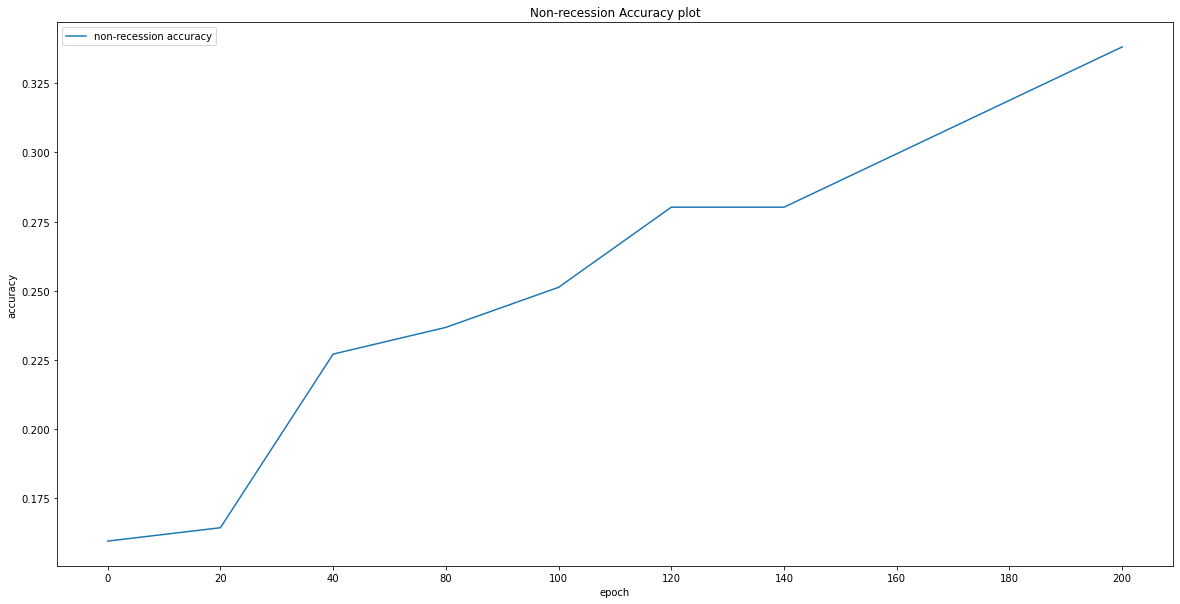

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

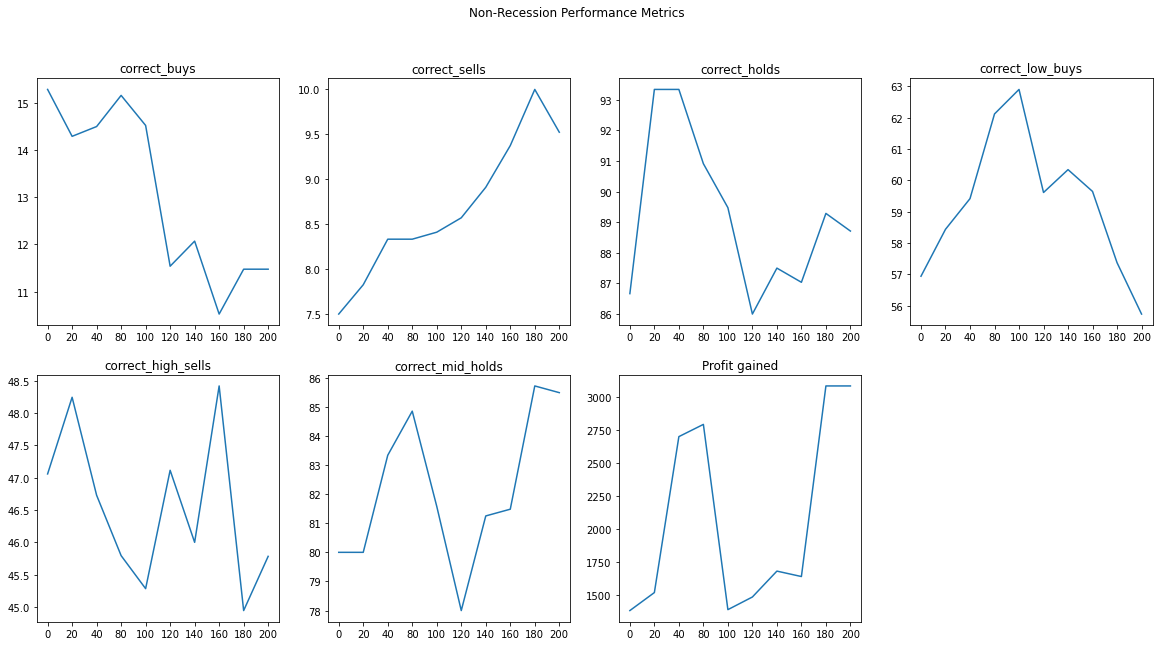

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

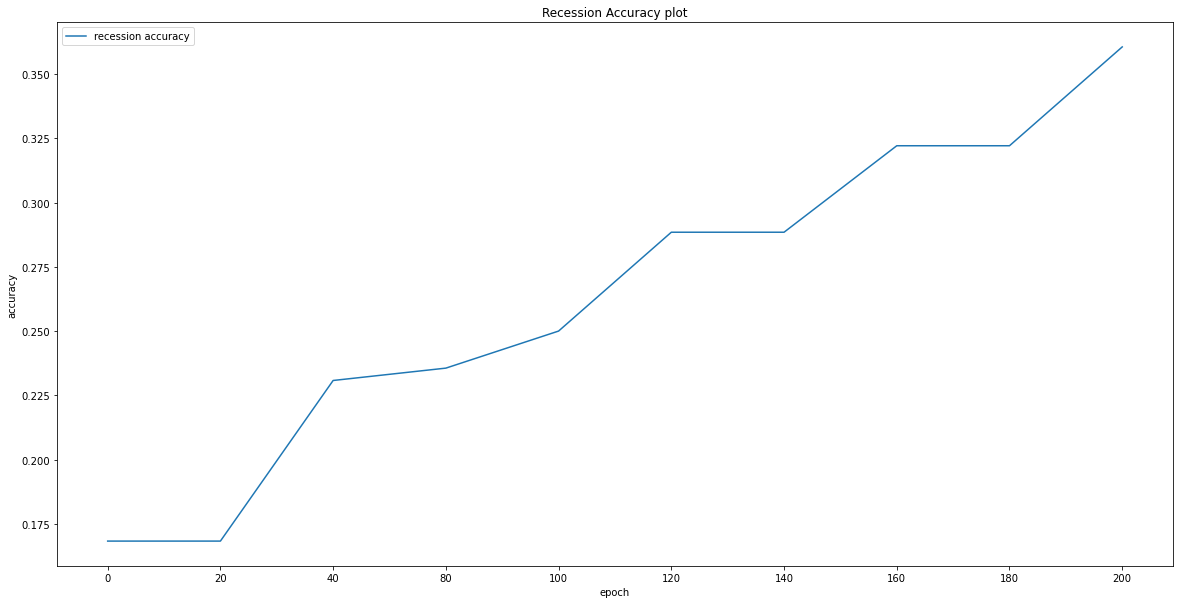

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(r_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

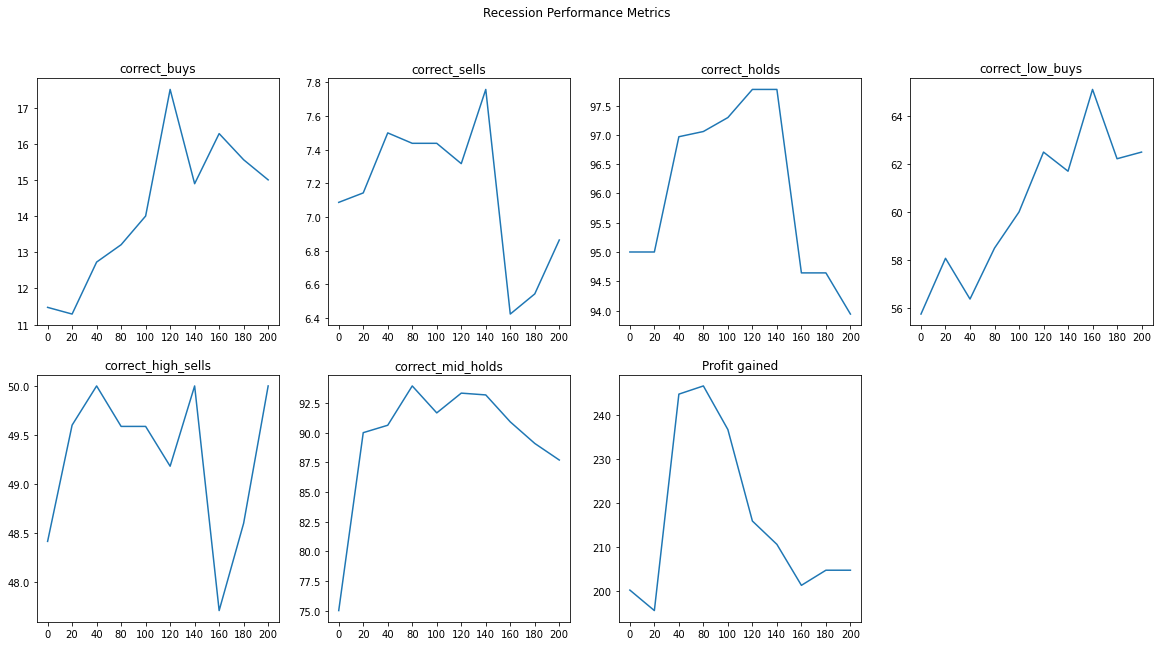

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

### Midea Group

In [22]:
nr_test_sets = ['000333.SZ']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_15 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1
    seq_new = []
    data_15 = []
    for i in range(0,len(sequential)):
        for j in range(0,len(sequential[i])):
            x = sequential[i][j]
            a = np.zeros(60)
            data_15.append(np.concatenate((x, a)))

        for j in range(1,50):
            x = np.zeros(64)
            data_15.append(x)
        seq_new.append(data_15)
        data_15 = []
        
    X = np.array(seq_new).reshape(-1, 64, 64, 1)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2019-01-22    42.090000  39.647816 -10.142844  258783172.0     2.0
2019-01-23    41.299999  39.901998 -21.428571  234314954.0     2.0
2019-01-24    41.459999  40.141691 -19.142859  253542262.0     2.0
2019-01-25    41.590000  40.364507 -19.706827  275498548.0     2.0
2019-01-28    41.900002  40.600737 -14.705848  302253363.0     2.0


In [23]:
r_test_sets = ['000333.SZ']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_15 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1
    seq_new = []
    data_15 = []
    for i in range(0,len(sequential)):
        for j in range(0,len(sequential[i])):
            x = sequential[i][j]
            a = np.zeros(60)
            data_15.append(np.concatenate((x, a)))

        for j in range(1,50):
            x = np.zeros(64)
            data_15.append(x)
        seq_new.append(data_15)
        data_15 = []
        
    X = np.array(seq_new).reshape(-1, 64, 64, 1)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-01-22    58.099998  59.163333 -58.000031  68400881.0     2.0
2020-01-23    57.480000  58.904359 -70.400009  27240262.0     2.0
2020-02-03    55.029999  58.308304 -99.500020 -27633268.0     1.0
2020-02-04    50.189999  57.059334 -94.741468 -98139988.0     2.0
2020-02-05    52.790001  56.402513 -71.954419 -57726889.0     2.0


### training Data

            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2013-10-17    11.912000  11.900182 -34.022038  235647532.0     1.0
2013-10-18    11.896000  11.899539 -39.103542  214825024.0     2.0
2013-10-21    12.269333  11.956430 -24.093825  253903732.0     2.0
2013-10-22    12.760000  12.080056  -4.424713  304775737.0     2.0
2013-10-23    12.645333  12.167022 -15.187657  273970459.0     2.0


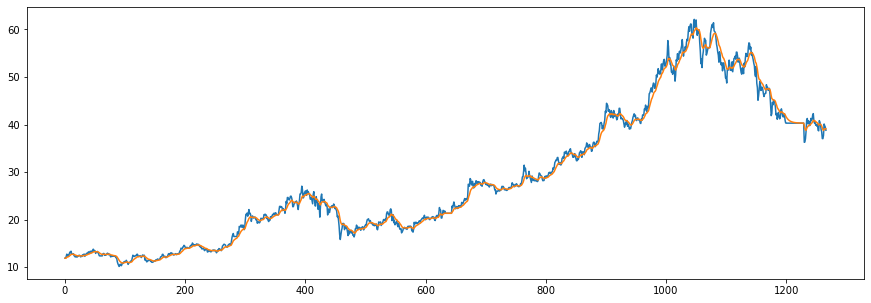

In [24]:
seed = 10
df = pd.read_csv('data/noncyclic_tickers/initial_indicators/000333.SZ_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
seq_new = []
data_15 = []
for i in range(0,len(sequential)):
    for j in range(0,len(sequential[i])):
        x = sequential[i][j]
        a = np.zeros(60)
        data_15.append(np.concatenate((x, a)))
        
    for j in range(1,50):
        x = np.zeros(64)
        data_15.append(x)
    seq_new.append(data_15)
    data_15 = []
    
X = np.array(seq_new).reshape(-1, 64, 64, 1)
y = labels
y = np.array(y)

In [25]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [26]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [27]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [28]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [29]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('000333.SZ')]
    y = nr_test_data['{}_y'.format('000333.SZ')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format('000333.SZ'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_non_recession.csv'.format(experiment,'000333.SZ')):
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'000333.SZ'))
    else:
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'000333.SZ'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('000333.SZ')]
    y = r_test_data['{}_y'.format('000333.SZ')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test2.csv".format('000333.SZ'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_recession.csv'.format(experiment,'000333.SZ')):
        log.to_csv('{}_{}_recession.csv'.format(experiment,'000333.SZ'))
    else:
        log.to_csv('{}_{}_recession.csv'.format(experiment,'000333.SZ'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.9523809523809526, 1: 6.816326530612245, 2: 0.36663007683863885}



RUNNING EPOCHS 0 - 20



Epoch 1/20
8/8 [==============================] - 1s 66ms/step - loss: 0.2481 - accuracy: 0.5828 - mse: 0.5406 - weighted_accuracy: 0.2652 - weighted_mse: 0.5974 - val_loss: 0.2026 - val_accuracy: 0.3068 - val_mse: 0.6756 - val_weighted_accuracy: 0.3068 - val_weighted_mse: 0.6756
Epoch 2/20
8/8 [==============================] - 0s 14ms/step - loss: 0.2127 - accuracy: 0.3982 - mse: 0.9090 - weighted_accuracy: 0.3221 - weighted_mse: 0.9324 - val_loss: 0.1908 - val_accuracy: 0.0717 - val_mse: 1.0339 - val_weighted_accuracy: 0.0717 - val_weighted_mse: 1.0339
Epoch 3/20
8/8 [==============================] - 0s 14ms/step - loss: 0.2109 - accuracy: 0.3503 - mse: 1.2252 - weighted_accuracy: 0.2723 - weighted_mse: 1.2359 - val_loss: 0.1900 - val_accuracy: 0.1076 - val_mse: 1.1969 - val_weighted_accuracy: 0.1076 - val_weighted_mse: 1.1969
Epoch 4/20
8/8 [==============================] - 0s 14ms/s

7/7 [==============================] - 0s 5ms/step - loss: 0.1964 - accuracy: 0.0769 - mse: 1.2052 - weighted_accuracy: 0.0769 - weighted_mse: 1.2052
Test loss: 0.19644387066364288
Test accuracy: 0.07692307978868484


number of predictions: 208
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 4
actual predicted sells: 4
actual sells but predicted hold: 0
actual holds but predicted buy: 88
actual holds but predicted sell: 99
actual predicted holds: 6
Percentage buys correct: 6.122448979591836%
Percentage sells correct: 3.8461538461538463%
Percentage holds correct: 100.0%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 47.95918367346939%
Percentage high sells correct: 48.54368932038835%
Percentage mid holds correct: 100.0%


Capital: 100
Share price: $0.1743489125058254
Shares owned at the moment: 571
Cash capital at the moment: $0.17299957931140852


Price increase from previously

Epoch 12/20
8/8 [==============================] - 0s 14ms/step - loss: 0.1750 - accuracy: 0.2485 - mse: 1.2733 - weighted_accuracy: 0.5185 - weighted_mse: 1.2081 - val_loss: 0.1980 - val_accuracy: 0.1275 - val_mse: 1.2063 - val_weighted_accuracy: 0.1275 - val_weighted_mse: 1.2063
Epoch 13/20
8/8 [==============================] - 0s 14ms/step - loss: 0.1750 - accuracy: 0.2196 - mse: 1.3370 - weighted_accuracy: 0.5715 - weighted_mse: 1.2461 - val_loss: 0.1952 - val_accuracy: 0.1394 - val_mse: 1.2445 - val_weighted_accuracy: 0.1394 - val_weighted_mse: 1.2445
Epoch 14/20
8/8 [==============================] - 0s 13ms/step - loss: 0.1750 - accuracy: 0.2495 - mse: 1.3287 - weighted_accuracy: 0.5590 - weighted_mse: 1.2793 - val_loss: 0.1925 - val_accuracy: 0.1753 - val_mse: 1.1595 - val_weighted_accuracy: 0.1753 - val_weighted_mse: 1.1595
Epoch 15/20
8/8 [==============================] - 0s 12ms/step - loss: 0.1726 - accuracy: 0.2705 - mse: 1.2945 - weighted_accuracy: 0.5826 - weighted_mse

7/7 [==============================] - 0s 3ms/step - loss: 0.1972 - accuracy: 0.1538 - mse: 1.2092 - weighted_accuracy: 0.1538 - weighted_mse: 1.2092
Test loss: 0.1972225457429886
Test accuracy: 0.1538461595773697


number of predictions: 208
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 4
actual sells but predicted hold: 2
actual holds but predicted buy: 71
actual holds but predicted sell: 100
actual predicted holds: 22
Percentage buys correct: 7.594936708860759%
Percentage sells correct: 3.8095238095238093%
Percentage holds correct: 91.66666666666667%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 53.164556962025316%
Percentage high sells correct: 49.03846153846154%
Percentage mid holds correct: 83.33333333333333%


Capital: 100
Share price: $0.1743489125058254
Shares owned at the moment: 571
Cash capital at the moment: $0.17299957931140852


Price

Epoch 13/20
8/8 [==============================] - 0s 17ms/step - loss: 0.1641 - accuracy: 0.2635 - mse: 1.4097 - weighted_accuracy: 0.6243 - weighted_mse: 1.3692 - val_loss: 0.1943 - val_accuracy: 0.2669 - val_mse: 1.1923 - val_weighted_accuracy: 0.2669 - val_weighted_mse: 1.1923
Epoch 14/20
8/8 [==============================] - 0s 16ms/step - loss: 0.1633 - accuracy: 0.2994 - mse: 1.3150 - weighted_accuracy: 0.6311 - weighted_mse: 1.2479 - val_loss: 0.1931 - val_accuracy: 0.2948 - val_mse: 1.1941 - val_weighted_accuracy: 0.2948 - val_weighted_mse: 1.1941
Epoch 15/20
8/8 [==============================] - 0s 17ms/step - loss: 0.1637 - accuracy: 0.2844 - mse: 1.4008 - weighted_accuracy: 0.5847 - weighted_mse: 1.3267 - val_loss: 0.1949 - val_accuracy: 0.2470 - val_mse: 1.2605 - val_weighted_accuracy: 0.2470 - val_weighted_mse: 1.2605
Epoch 16/20
8/8 [==============================] - 0s 16ms/step - loss: 0.1631 - accuracy: 0.2585 - mse: 1.4084 - weighted_accuracy: 0.5968 - weighted_mse

Epoch 1/20
8/8 [==============================] - 0s 23ms/step - loss: 0.1605 - accuracy: 0.3134 - mse: 1.4719 - weighted_accuracy: 0.6029 - weighted_mse: 1.3521 - val_loss: 0.1914 - val_accuracy: 0.2948 - val_mse: 1.3173 - val_weighted_accuracy: 0.2948 - val_weighted_mse: 1.3173
Epoch 2/20
8/8 [==============================] - 0s 16ms/step - loss: 0.1622 - accuracy: 0.2974 - mse: 1.4650 - weighted_accuracy: 0.6315 - weighted_mse: 1.3623 - val_loss: 0.1957 - val_accuracy: 0.2669 - val_mse: 1.3140 - val_weighted_accuracy: 0.2669 - val_weighted_mse: 1.3140
Epoch 3/20
8/8 [==============================] - 0s 19ms/step - loss: 0.1641 - accuracy: 0.2385 - mse: 1.4848 - weighted_accuracy: 0.5754 - weighted_mse: 1.3750 - val_loss: 0.2002 - val_accuracy: 0.2311 - val_mse: 1.3004 - val_weighted_accuracy: 0.2311 - val_weighted_mse: 1.3004
Epoch 4/20
8/8 [==============================] - 0s 18ms/step - loss: 0.1585 - accuracy: 0.2645 - mse: 1.4752 - weighted_accuracy: 0.6345 - weighted_mse: 1.

7/7 [==============================] - 0s 2ms/step - loss: 0.1926 - accuracy: 0.3317 - mse: 1.4759 - weighted_accuracy: 0.3317 - weighted_mse: 1.4759
Test loss: 0.19262894988059998
Test accuracy: 0.33173078298568726


number of predictions: 208
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 4
actual sells but predicted hold: 3
actual holds but predicted buy: 57
actual holds but predicted sell: 78
actual predicted holds: 58
Percentage buys correct: 10.76923076923077%
Percentage sells correct: 4.878048780487805%
Percentage holds correct: 95.08196721311475%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 64.61538461538461%
Percentage high sells correct: 53.65853658536585%
Percentage mid holds correct: 90.0%


Capital: 100
Share price: $0.1863590200873636
Shares owned at the moment: 535
Cash capital at the moment: $0.023743544956943197


Price increase fro

Epoch 10/20
8/8 [==============================] - 0s 16ms/step - loss: 0.1484 - accuracy: 0.3842 - mse: 1.5760 - weighted_accuracy: 0.6622 - weighted_mse: 1.5536 - val_loss: 0.1829 - val_accuracy: 0.3944 - val_mse: 1.4157 - val_weighted_accuracy: 0.3944 - val_weighted_mse: 1.4157
Epoch 11/20
8/8 [==============================] - 0s 16ms/step - loss: 0.1473 - accuracy: 0.3902 - mse: 1.6084 - weighted_accuracy: 0.6451 - weighted_mse: 1.5495 - val_loss: 0.1849 - val_accuracy: 0.3785 - val_mse: 1.4043 - val_weighted_accuracy: 0.3785 - val_weighted_mse: 1.4043
Epoch 12/20
8/8 [==============================] - 0s 17ms/step - loss: 0.1482 - accuracy: 0.3423 - mse: 1.6150 - weighted_accuracy: 0.6620 - weighted_mse: 1.4996 - val_loss: 0.1912 - val_accuracy: 0.3147 - val_mse: 1.4467 - val_weighted_accuracy: 0.3147 - val_weighted_mse: 1.4467
Epoch 13/20
8/8 [==============================] - 0s 17ms/step - loss: 0.1477 - accuracy: 0.3124 - mse: 1.6103 - weighted_accuracy: 0.6510 - weighted_mse



Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.1920 - accuracy: 0.3462 - mse: 1.4871 - weighted_accuracy: 0.3462 - weighted_mse: 1.4871
Test loss: 0.19195519387722015
Test accuracy: 0.3461538553237915


number of predictions: 208
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 4
actual sells but predicted hold: 3
actual holds but predicted buy: 56
actual holds but predicted sell: 76
actual predicted holds: 61
Percentage buys correct: 10.9375%
Percentage sells correct: 5.0%
Percentage holds correct: 95.3125%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 64.0625%
Percentage high sells correct: 56.25%
Percentage mid holds correct: 88.88888888888889%


Capital: 100
Share price: $0.1863590200873636
Shares owned at the moment: 535
Cash capital at the moment: $0.023743544956943197


Price increase from previously bought: 9.76

Epoch 10/20
8/8 [==============================] - 0s 17ms/step - loss: 0.1429 - accuracy: 0.3932 - mse: 1.7326 - weighted_accuracy: 0.6969 - weighted_mse: 1.6670 - val_loss: 0.1809 - val_accuracy: 0.4183 - val_mse: 1.4717 - val_weighted_accuracy: 0.4183 - val_weighted_mse: 1.4717
Epoch 11/20
8/8 [==============================] - 0s 17ms/step - loss: 0.1405 - accuracy: 0.4132 - mse: 1.6758 - weighted_accuracy: 0.7247 - weighted_mse: 1.5921 - val_loss: 0.1823 - val_accuracy: 0.4064 - val_mse: 1.5237 - val_weighted_accuracy: 0.4064 - val_weighted_mse: 1.5237
Epoch 12/20
8/8 [==============================] - 0s 17ms/step - loss: 0.1419 - accuracy: 0.3593 - mse: 1.7728 - weighted_accuracy: 0.7038 - weighted_mse: 1.7075 - val_loss: 0.1874 - val_accuracy: 0.3705 - val_mse: 1.5578 - val_weighted_accuracy: 0.3705 - val_weighted_mse: 1.5578
Epoch 13/20
8/8 [==============================] - 0s 17ms/step - loss: 0.1428 - accuracy: 0.3812 - mse: 1.7408 - weighted_accuracy: 0.6978 - weighted_mse

7/7 [==============================] - 0s 2ms/step - loss: 0.1928 - accuracy: 0.3750 - mse: 1.4618 - weighted_accuracy: 0.3750 - weighted_mse: 1.4618
Test loss: 0.19284303486347198
Test accuracy: 0.375


number of predictions: 208
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 4
actual holds but predicted buy: 45
actual holds but predicted sell: 80
actual predicted holds: 68
Percentage buys correct: 11.764705882352942%
Percentage sells correct: 4.761904761904762%
Percentage holds correct: 93.15068493150685%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 66.66666666666667%
Percentage high sells correct: 55.95238095238095%
Percentage mid holds correct: 86.11111111111111%


Capital: 100
Share price: $0.1863590200873636
Shares owned at the moment: 535
Cash capital at the moment: $0.023743544956943197


Price increase fro

Epoch 10/20
8/8 [==============================] - 0s 15ms/step - loss: 0.1378 - accuracy: 0.4092 - mse: 1.7815 - weighted_accuracy: 0.6940 - weighted_mse: 1.8202 - val_loss: 0.1846 - val_accuracy: 0.4143 - val_mse: 1.5219 - val_weighted_accuracy: 0.4143 - val_weighted_mse: 1.5219
Epoch 11/20
8/8 [==============================] - 0s 15ms/step - loss: 0.1380 - accuracy: 0.4052 - mse: 1.7107 - weighted_accuracy: 0.7130 - weighted_mse: 1.6461 - val_loss: 0.1874 - val_accuracy: 0.3904 - val_mse: 1.5026 - val_weighted_accuracy: 0.3904 - val_weighted_mse: 1.5026
Epoch 12/20
8/8 [==============================] - 0s 15ms/step - loss: 0.1339 - accuracy: 0.3902 - mse: 1.7261 - weighted_accuracy: 0.7431 - weighted_mse: 1.7139 - val_loss: 0.1880 - val_accuracy: 0.3984 - val_mse: 1.6007 - val_weighted_accuracy: 0.3984 - val_weighted_mse: 1.6007
Epoch 13/20
8/8 [==============================] - 0s 14ms/step - loss: 0.1347 - accuracy: 0.4192 - mse: 1.8195 - weighted_accuracy: 0.7397 - weighted_mse

7/7 [==============================] - 0s 3ms/step - loss: 0.1830 - accuracy: 0.4183 - mse: 1.6726 - weighted_accuracy: 0.4183 - weighted_mse: 1.6726
Test loss: 0.18302369117736816
Test accuracy: 0.41826921701431274


number of predictions: 208
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 4
actual holds but predicted buy: 47
actual holds but predicted sell: 69
actual predicted holds: 77
Percentage buys correct: 11.320754716981131%
Percentage sells correct: 5.47945205479452%
Percentage holds correct: 93.90243902439025%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 67.9245283018868%
Percentage high sells correct: 56.16438356164384%
Percentage mid holds correct: 86.41975308641975%


Capital: 100
Share price: $0.17350607819695518
Shares owned at the moment: 574
Cash capital at the moment: $0.1336317705138299


Price i

Epoch 10/20
8/8 [==============================] - 0s 14ms/step - loss: 0.1345 - accuracy: 0.4780 - mse: 1.8301 - weighted_accuracy: 0.7549 - weighted_mse: 1.8056 - val_loss: 0.1738 - val_accuracy: 0.4861 - val_mse: 1.6154 - val_weighted_accuracy: 0.4861 - val_weighted_mse: 1.6154
Epoch 11/20
8/8 [==============================] - 0s 13ms/step - loss: 0.1342 - accuracy: 0.4611 - mse: 1.8114 - weighted_accuracy: 0.7464 - weighted_mse: 1.7395 - val_loss: 0.1765 - val_accuracy: 0.4741 - val_mse: 1.6110 - val_weighted_accuracy: 0.4741 - val_weighted_mse: 1.6110
Epoch 12/20
8/8 [==============================] - 0s 13ms/step - loss: 0.1314 - accuracy: 0.4441 - mse: 1.8608 - weighted_accuracy: 0.7640 - weighted_mse: 1.8578 - val_loss: 0.1812 - val_accuracy: 0.4462 - val_mse: 1.6573 - val_weighted_accuracy: 0.4462 - val_weighted_mse: 1.6573
Epoch 13/20
8/8 [==============================] - 0s 13ms/step - loss: 0.1295 - accuracy: 0.4641 - mse: 1.8554 - weighted_accuracy: 0.7831 - weighted_mse

7/7 [==============================] - 0s 3ms/step - loss: 0.1798 - accuracy: 0.4375 - mse: 1.7076 - weighted_accuracy: 0.4375 - weighted_mse: 1.7076
Test loss: 0.17984017729759216
Test accuracy: 0.4375


number of predictions: 208
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 4
actual holds but predicted buy: 40
actual holds but predicted sell: 71
actual predicted holds: 82
Percentage buys correct: 11.11111111111111%
Percentage sells correct: 5.333333333333333%
Percentage holds correct: 93.18181818181819%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 66.66666666666667%
Percentage high sells correct: 54.666666666666664%
Percentage mid holds correct: 85.05747126436782%


Capital: 100
Share price: $0.17350607819695518
Shares owned at the moment: 574
Cash capital at the moment: $0.1336317705138299


Price increase fro

Epoch 11/20
8/8 [==============================] - 0s 13ms/step - loss: 0.1219 - accuracy: 0.5269 - mse: 1.9299 - weighted_accuracy: 0.7997 - weighted_mse: 1.9772 - val_loss: 0.1743 - val_accuracy: 0.4900 - val_mse: 1.7237 - val_weighted_accuracy: 0.4900 - val_weighted_mse: 1.7237
Epoch 12/20
8/8 [==============================] - 0s 13ms/step - loss: 0.1303 - accuracy: 0.4511 - mse: 1.9979 - weighted_accuracy: 0.7416 - weighted_mse: 1.9487 - val_loss: 0.1779 - val_accuracy: 0.4701 - val_mse: 1.7400 - val_weighted_accuracy: 0.4701 - val_weighted_mse: 1.7400
Epoch 13/20
8/8 [==============================] - 0s 14ms/step - loss: 0.1226 - accuracy: 0.5010 - mse: 1.9624 - weighted_accuracy: 0.7686 - weighted_mse: 2.0100 - val_loss: 0.1698 - val_accuracy: 0.5179 - val_mse: 1.7376 - val_weighted_accuracy: 0.5179 - val_weighted_mse: 1.7376
Epoch 14/20
8/8 [==============================] - 0s 14ms/step - loss: 0.1280 - accuracy: 0.4860 - mse: 1.9910 - weighted_accuracy: 0.7222 - weighted_mse

7/7 [==============================] - 0s 3ms/step - loss: 0.1810 - accuracy: 0.4375 - mse: 1.7905 - weighted_accuracy: 0.4375 - weighted_mse: 1.7905
Test loss: 0.18102310597896576
Test accuracy: 0.4375


number of predictions: 208
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 4
actual holds but predicted buy: 43
actual holds but predicted sell: 68
actual predicted holds: 82
Percentage buys correct: 10.416666666666666%
Percentage sells correct: 5.555555555555555%
Percentage holds correct: 93.18181818181819%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 68.75%
Percentage high sells correct: 55.55555555555556%
Percentage mid holds correct: 86.20689655172414%


Capital: 100
Share price: $0.17350607819695518
Shares owned at the moment: 574
Cash capital at the moment: $0.1336317705138299


Price increase from previously

Epoch 9/20
8/8 [==============================] - 0s 13ms/step - loss: 0.1188 - accuracy: 0.5190 - mse: 2.1271 - weighted_accuracy: 0.8032 - weighted_mse: 2.1613 - val_loss: 0.1659 - val_accuracy: 0.5418 - val_mse: 1.8931 - val_weighted_accuracy: 0.5418 - val_weighted_mse: 1.8931
Epoch 10/20
8/8 [==============================] - 0s 12ms/step - loss: 0.1211 - accuracy: 0.5758 - mse: 2.1645 - weighted_accuracy: 0.7593 - weighted_mse: 2.2377 - val_loss: 0.1644 - val_accuracy: 0.5458 - val_mse: 1.8370 - val_weighted_accuracy: 0.5458 - val_weighted_mse: 1.8370
Epoch 11/20
8/8 [==============================] - 0s 16ms/step - loss: 0.1253 - accuracy: 0.4970 - mse: 2.0308 - weighted_accuracy: 0.7414 - weighted_mse: 2.0626 - val_loss: 0.1830 - val_accuracy: 0.4582 - val_mse: 1.7901 - val_weighted_accuracy: 0.4582 - val_weighted_mse: 1.7901
Epoch 12/20
8/8 [==============================] - 0s 14ms/step - loss: 0.1210 - accuracy: 0.4371 - mse: 2.0178 - weighted_accuracy: 0.7645 - weighted_mse:

Capital at the end of test period if Buy and Hold: $1345.2754815401652
profit gained: 1245.2754815401652%
   Test_accuracy  correct_buys  correct_sells  correct_holds  \
0        0.47343     10.526316       9.259259         90.625   

   correct_low_buys  correct_high_sells  correct_mid_holds  Profit gained  \
0         64.285714           55.555556          77.083333     869.312546   

   buy_n_hold profit  
0        1245.275482  


Recession Test


7/7 [==============================] - 0s 2ms/step - loss: 0.1687 - accuracy: 0.5000 - mse: 1.8372 - weighted_accuracy: 0.5000 - weighted_mse: 1.8372
Test loss: 0.16872447729110718
Test accuracy: 0.5


number of predictions: 208
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 5
actual holds but predicted buy: 35
actual holds but predicted sell: 62
actual predicted holds: 96
Percentage buys correct: 12.5%

In [30]:
df = r_log_hist['epochs_logs']
df.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.076923,6.122449,3.846154,100.000000,47.959184,48.543689,100.000000,27.727926,468.573309
1,0.153846,7.594937,3.809524,91.666667,53.164557,49.038462,83.333333,97.659226,468.573309
2,0.307692,9.230769,3.571429,93.220339,58.461538,51.807229,91.525424,67.277893,468.573309
3,0.331731,10.769231,4.878049,95.081967,64.615385,53.658537,90.000000,13.008030,468.573309
4,0.346154,10.937500,5.000000,95.312500,64.062500,56.250000,88.888889,28.565629,468.573309
5,0.375000,11.764706,4.761905,93.150685,66.666667,55.952381,86.111111,27.494527,468.573309
6,0.418269,11.320755,5.479452,93.902439,67.924528,56.164384,86.419753,45.500622,468.573309
7,0.437500,11.111111,5.333333,93.181818,66.666667,54.666667,85.057471,36.016046,468.573309
8,0.437500,10.416667,5.555556,93.181818,68.750000,55.555556,86.206897,35.193316,468.573309
9,0.500000,12.500000,4.615385,93.203883,67.500000,52.307692,86.274510,7.561790,468.573309


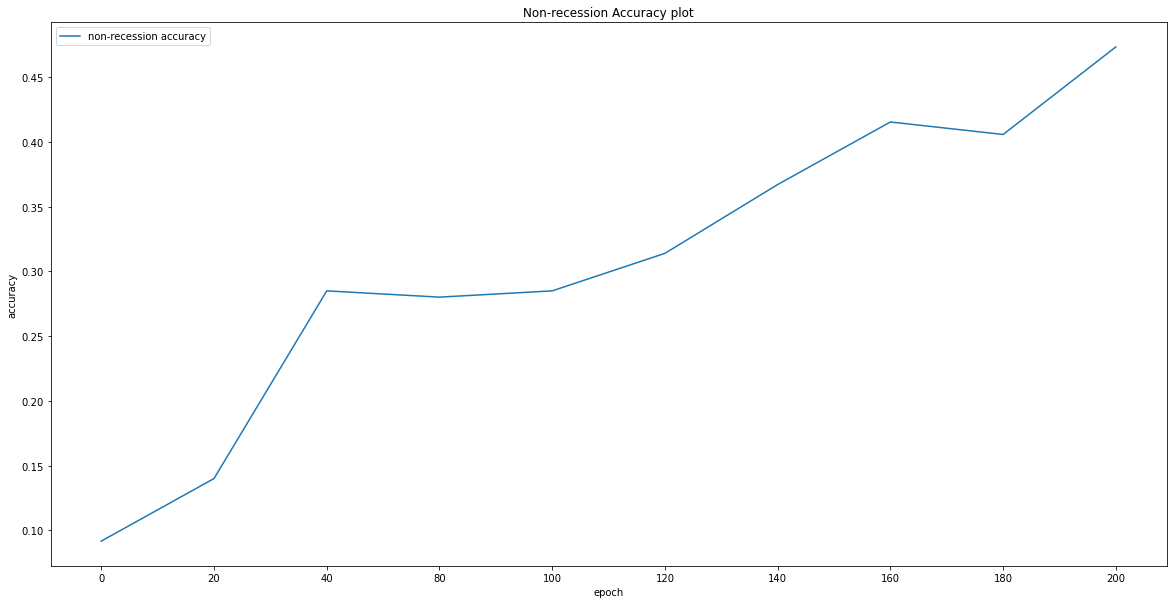

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

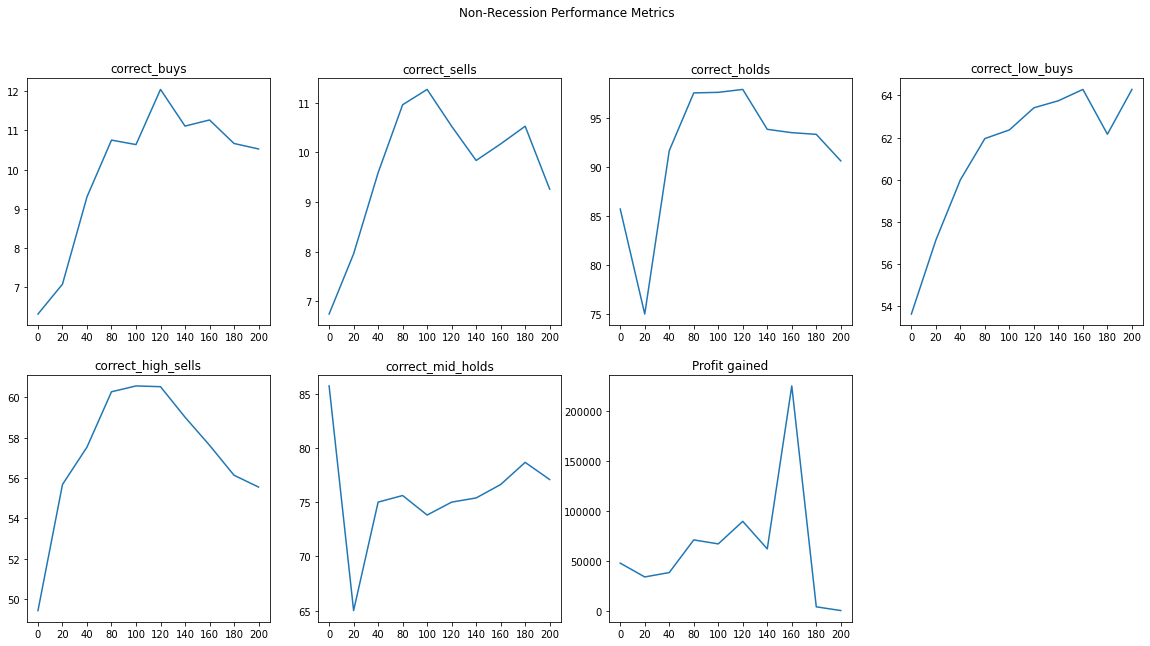

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

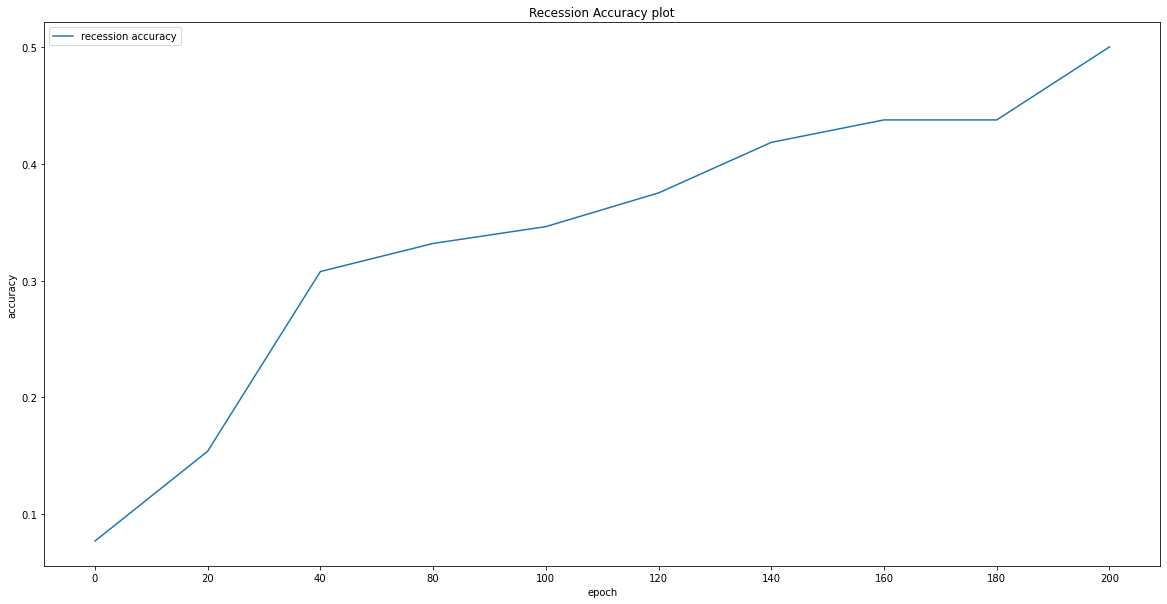

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(r_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

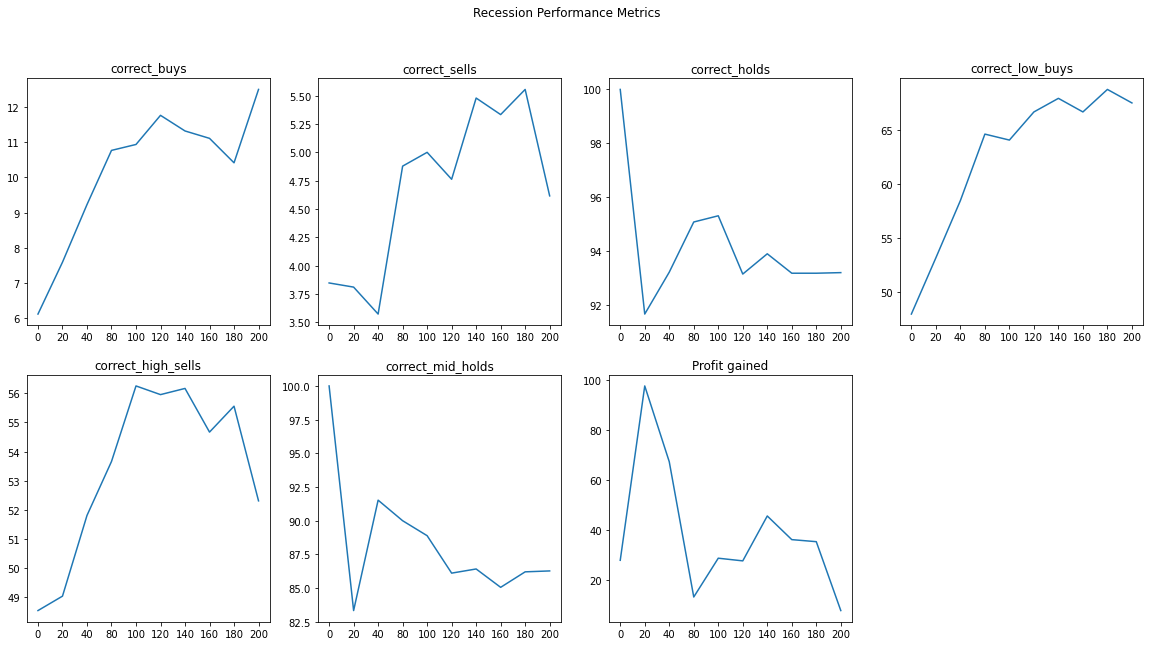

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

### Walmart

In [35]:
nr_test_sets = ['WMT']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_15 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1
    seq_new = []
    data_15 = []
    for i in range(0,len(sequential)):
        for j in range(0,len(sequential[i])):
            x = sequential[i][j]
            a = np.zeros(60)
            data_15.append(np.concatenate((x, a)))

        for j in range(1,50):
            x = np.zeros(64)
            data_15.append(x)
        seq_new.append(data_15)
        data_15 = []
        
    X = np.array(seq_new).reshape(-1, 64, 64, 1)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-22    97.730003  95.334462  -7.164539  58918700.0     2.0
2019-01-23    97.489998  95.666083 -13.843922  50855500.0     0.0
2019-01-24    98.709999  96.134378  -9.609606  59201300.0     2.0
2019-01-25    98.360001  96.476781 -14.864842  51591600.0     2.0
2019-01-28    96.940002  96.548046 -38.683751  44373400.0     2.0


In [36]:
r_test_sets = ['WMT']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_15 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1
    seq_new = []
    data_15 = []
    for i in range(0,len(sequential)):
        for j in range(0,len(sequential[i])):
            x = sequential[i][j]
            a = np.zeros(60)
            data_15.append(np.concatenate((x, a)))

        for j in range(1,50):
            x = np.zeros(64)
            data_15.append(x)
        seq_new.append(data_15)
        data_15 = []
        
    X = np.array(seq_new).reshape(-1, 64, 64, 1)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2020-01-22   115.589996  116.459043 -80.074504 -17684500.0     2.0
2020-01-23   116.099998  116.403805 -70.577262 -12758400.0     2.0
2020-01-24   115.809998  116.312450 -69.789236 -17063500.0     2.0
2020-01-27   114.370003  116.013612 -94.416205 -21446900.0     2.0
2020-01-28   115.860001  115.989979 -34.297465 -14428500.0     2.0


### Training Data

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2000-01-21      63.3750  65.176128 -85.271318 -26649200.0     2.0
2000-01-24      62.4375  64.754801 -94.594595 -33601700.0     2.0
2000-01-25      59.3750  63.927139 -83.606557 -41401600.0     2.0
2000-01-26      61.1250  63.496041 -68.306011 -34997800.0     2.0
2000-01-27      61.9375  63.256265 -61.202186 -30459400.0     2.0


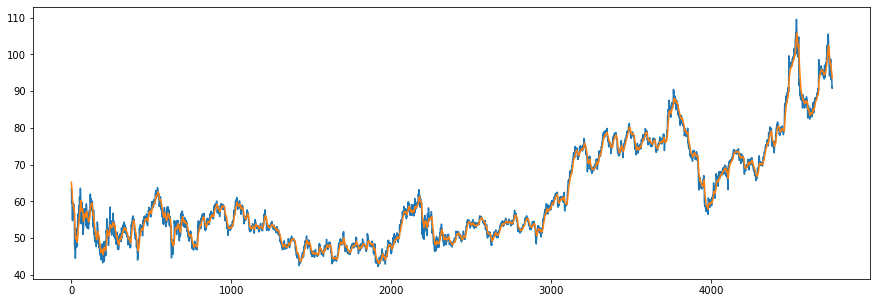

In [37]:
seed = 10
df = pd.read_csv('data/noncyclic_tickers/initial_indicators/WMT_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
seq_new = []
data_15 = []
for i in range(0,len(sequential)):
    for j in range(0,len(sequential[i])):
        x = sequential[i][j]
        a = np.zeros(60)
        data_15.append(np.concatenate((x, a)))
        
    for j in range(1,50):
        x = np.zeros(64)
        data_15.append(x)
    seq_new.append(data_15)
    data_15 = []
    
X = np.array(seq_new).reshape(-1, 64, 64, 1)
y = labels
y = np.array(y)

In [38]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [39]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [40]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [41]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [42]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('WMT')]
    y = nr_test_data['{}_y'.format('WMT')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format('WMT'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_non_recession.csv'.format(experiment,'WMT')):
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'WMT'))
    else:
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'WMT'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('WMT')]
    y = r_test_data['{}_y'.format('WMT')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test2.csv".format('WMT'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_recession.csv'.format(experiment,'WMT')):
        log.to_csv('{}_{}_recession.csv'.format(experiment,'WMT'))
    else:
        log.to_csv('{}_{}_recession.csv'.format(experiment,'WMT'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.148775894538606, 1: 7.3565891472868215, 2: 0.3670824871869258}



RUNNING EPOCHS 0 - 20



Epoch 1/20
30/30 [==============================] - 1s 25ms/step - loss: 0.2185 - accuracy: 0.4428 - mse: 0.9606 - weighted_accuracy: 0.3221 - weighted_mse: 1.0161 - val_loss: 0.1824 - val_accuracy: 0.7134 - val_mse: 1.1144 - val_weighted_accuracy: 0.7134 - val_weighted_mse: 1.1144
Epoch 2/20
30/30 [==============================] - 0s 14ms/step - loss: 0.2052 - accuracy: 0.4692 - mse: 1.1475 - weighted_accuracy: 0.3671 - weighted_mse: 1.1864 - val_loss: 0.1850 - val_accuracy: 0.4847 - val_mse: 1.0324 - val_weighted_accuracy: 0.4847 - val_weighted_mse: 1.0324
Epoch 3/20
30/30 [==============================] - 0s 14ms/step - loss: 0.1981 - accuracy: 0.3793 - mse: 1.1561 - weighted_accuracy: 0.4031 - weighted_mse: 1.1571 - val_loss: 0.1878 - val_accuracy: 0.2561 - val_mse: 1.0987 - val_weighted_accuracy: 0.2561 - val_weighted_mse: 1.0987
Epoch 4/20
30/30 [==============================] - 0s

Share price: $0.8911804023136407
Shares owned at the moment: 0
Cash capital at the moment: $119.1165267202282


Share price: $0.8118340965769335
Shares owned at the moment: 146
Cash capital at the moment: $0.2627972302202579


Price increase from previously bought: 15.88893454999547%
Share price: $0.9434131560198902
Shares owned at the moment: 0
Cash capital at the moment: $137.62233762698222


Share price: $0.9206858971199952
Shares owned at the moment: 149
Cash capital at the moment: $0.06288790975801817


Price increase from previously bought: 1.712421926862917%
Share price: $0.939027167091637
Shares owned at the moment: 0
Cash capital at the moment: $139.59316942469616


Share price: $0.9689314711284631
Shares owned at the moment: 143
Cash capital at the moment: $0.6549367523046783


Price increase from previously bought: -2.20303912612807%
Share price: $0.9501913919263487
Shares owned at the moment: 0
Cash capital at the moment: $136.15864303289752


Share price: $0.91909096440042

Epoch 4/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1689 - accuracy: 0.2287 - mse: 1.4325 - weighted_accuracy: 0.5540 - weighted_mse: 1.3679 - val_loss: 0.2022 - val_accuracy: 0.1538 - val_mse: 1.3900 - val_weighted_accuracy: 0.1538 - val_weighted_mse: 1.3900
Epoch 5/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1697 - accuracy: 0.2102 - mse: 1.4258 - weighted_accuracy: 0.5668 - weighted_mse: 1.3354 - val_loss: 0.2019 - val_accuracy: 0.1644 - val_mse: 1.3775 - val_weighted_accuracy: 0.1644 - val_weighted_mse: 1.3775
Epoch 6/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1679 - accuracy: 0.2302 - mse: 1.4331 - weighted_accuracy: 0.5836 - weighted_mse: 1.3600 - val_loss: 0.2017 - val_accuracy: 0.1560 - val_mse: 1.3875 - val_weighted_accuracy: 0.1560 - val_weighted_mse: 1.3875
Epoch 7/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1680 - accuracy: 0.2271 - mse: 1.4573 - weighted_accuracy: 0.5733 - weighted

7/7 [==============================] - 0s 3ms/step - loss: 0.1962 - accuracy: 0.1872 - mse: 1.4297 - weighted_accuracy: 0.1872 - weighted_mse: 1.4297
Test loss: 0.19619138538837433
Test accuracy: 0.18721461296081543


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 0
actual predicted sells: 11
actual sells but predicted hold: 0
actual holds but predicted buy: 86
actual holds but predicted sell: 91
actual predicted holds: 24
Percentage buys correct: 6.521739130434782%
Percentage sells correct: 10.679611650485437%
Percentage holds correct: 100.0%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 51.64835164835165%
Percentage high sells correct: 47.57281553398058%
Percentage mid holds correct: 91.66666666666667%


Capital: 100
Share price: $0.24286829602432447
Shares owned at the moment: 410
Cash capital at the moment: $0.15016462625953864


Price increase

30/30 [==============================] - 0s 16ms/step - loss: 0.1609 - accuracy: 0.2555 - mse: 1.5669 - weighted_accuracy: 0.6039 - weighted_mse: 1.4819 - val_loss: 0.1983 - val_accuracy: 0.1865 - val_mse: 1.5173 - val_weighted_accuracy: 0.1865 - val_weighted_mse: 1.5173
Epoch 9/20
30/30 [==============================] - 1s 17ms/step - loss: 0.1607 - accuracy: 0.2302 - mse: 1.5891 - weighted_accuracy: 0.5996 - weighted_mse: 1.4909 - val_loss: 0.2025 - val_accuracy: 0.1886 - val_mse: 1.5263 - val_weighted_accuracy: 0.1886 - val_weighted_mse: 1.5263
Epoch 10/20
30/30 [==============================] - 1s 17ms/step - loss: 0.1588 - accuracy: 0.2100 - mse: 1.6019 - weighted_accuracy: 0.5978 - weighted_mse: 1.5282 - val_loss: 0.2031 - val_accuracy: 0.1876 - val_mse: 1.5214 - val_weighted_accuracy: 0.1876 - val_weighted_mse: 1.5214
Epoch 11/20
30/30 [==============================] - 1s 20ms/step - loss: 0.1573 - accuracy: 0.2092 - mse: 1.5894 - weighted_accuracy: 0.6118 - weighted_mse: 1.5

7/7 [==============================] - 0s 4ms/step - loss: 0.1966 - accuracy: 0.2100 - mse: 1.5279 - weighted_accuracy: 0.2100 - weighted_mse: 1.5279
Test loss: 0.19659703969955444
Test accuracy: 0.21004566550254822


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 0
actual predicted sells: 11
actual sells but predicted hold: 0
actual holds but predicted buy: 87
actual holds but predicted sell: 85
actual predicted holds: 29
Percentage buys correct: 6.451612903225806%
Percentage sells correct: 11.458333333333334%
Percentage holds correct: 96.66666666666667%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 52.17391304347826%
Percentage high sells correct: 47.916666666666664%
Percentage mid holds correct: 86.66666666666667%


Capital: 100
Share price: $0.24286829602432447
Shares owned at the moment: 410
Cash capital at the moment: $0.15016462625953864


P

30/30 [==============================] - 0s 12ms/step - loss: 0.1557 - accuracy: 0.2352 - mse: 1.6665 - weighted_accuracy: 0.6287 - weighted_mse: 1.5678 - val_loss: 0.1988 - val_accuracy: 0.2339 - val_mse: 1.6289 - val_weighted_accuracy: 0.2339 - val_weighted_mse: 1.6289
Epoch 10/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1548 - accuracy: 0.2468 - mse: 1.6987 - weighted_accuracy: 0.6185 - weighted_mse: 1.6095 - val_loss: 0.2019 - val_accuracy: 0.2097 - val_mse: 1.5991 - val_weighted_accuracy: 0.2097 - val_weighted_mse: 1.5991
Epoch 11/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1533 - accuracy: 0.2439 - mse: 1.6955 - weighted_accuracy: 0.6319 - weighted_mse: 1.6126 - val_loss: 0.1912 - val_accuracy: 0.2466 - val_mse: 1.6303 - val_weighted_accuracy: 0.2466 - val_weighted_mse: 1.6303
Epoch 12/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1515 - accuracy: 0.2803 - mse: 1.7245 - weighted_accuracy: 0.6361 - weighted_mse: 1.



Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.1937 - accuracy: 0.2374 - mse: 1.6819 - weighted_accuracy: 0.2374 - weighted_mse: 1.6819
Test loss: 0.19365090131759644
Test accuracy: 0.23744292557239532


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 0
actual predicted sells: 11
actual sells but predicted hold: 0
actual holds but predicted buy: 84
actual holds but predicted sell: 82
actual predicted holds: 35
Percentage buys correct: 6.666666666666667%
Percentage sells correct: 11.827956989247312%
Percentage holds correct: 97.22222222222223%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 52.80898876404494%
Percentage high sells correct: 49.46236559139785%
Percentage mid holds correct: 88.88888888888889%


Capital: 100
Share price: $0.24286829602432447
Shares owned at the moment: 410
Cash capital at the moment: $0.150

30/30 [==============================] - 0s 16ms/step - loss: 0.1489 - accuracy: 0.2832 - mse: 1.8170 - weighted_accuracy: 0.6481 - weighted_mse: 1.7234 - val_loss: 0.2000 - val_accuracy: 0.2308 - val_mse: 1.6825 - val_weighted_accuracy: 0.2308 - val_weighted_mse: 1.6825
Epoch 11/20
30/30 [==============================] - 0s 14ms/step - loss: 0.1483 - accuracy: 0.2542 - mse: 1.7940 - weighted_accuracy: 0.6464 - weighted_mse: 1.6944 - val_loss: 0.1960 - val_accuracy: 0.2592 - val_mse: 1.7613 - val_weighted_accuracy: 0.2592 - val_weighted_mse: 1.7613
Epoch 12/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1464 - accuracy: 0.3145 - mse: 1.8340 - weighted_accuracy: 0.6561 - weighted_mse: 1.7762 - val_loss: 0.1944 - val_accuracy: 0.2487 - val_mse: 1.6822 - val_weighted_accuracy: 0.2487 - val_weighted_mse: 1.6822
Epoch 13/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1457 - accuracy: 0.2792 - mse: 1.8529 - weighted_accuracy: 0.6594 - weighted_mse: 1.

7/7 [==============================] - 0s 3ms/step - loss: 0.1959 - accuracy: 0.2283 - mse: 1.7177 - weighted_accuracy: 0.2283 - weighted_mse: 1.7177
Test loss: 0.19585376977920532
Test accuracy: 0.2283104956150055


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 0
actual predicted sells: 11
actual sells but predicted hold: 0
actual holds but predicted buy: 78
actual holds but predicted sell: 90
actual predicted holds: 33
Percentage buys correct: 7.142857142857143%
Percentage sells correct: 10.784313725490197%
Percentage holds correct: 100.0%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 55.42168674698795%
Percentage high sells correct: 45.09803921568628%
Percentage mid holds correct: 90.9090909090909%


Capital: 100
Share price: $0.22214604861775533
Shares owned at the moment: 448
Cash capital at the moment: $0.2048862873485291


Price increase fr

30/30 [==============================] - 0s 16ms/step - loss: 0.1430 - accuracy: 0.2961 - mse: 1.8674 - weighted_accuracy: 0.6765 - weighted_mse: 1.8087 - val_loss: 0.1962 - val_accuracy: 0.2476 - val_mse: 1.7730 - val_weighted_accuracy: 0.2476 - val_weighted_mse: 1.7730
Epoch 9/20
30/30 [==============================] - 0s 16ms/step - loss: 0.1434 - accuracy: 0.2956 - mse: 1.9432 - weighted_accuracy: 0.6724 - weighted_mse: 1.8482 - val_loss: 0.1933 - val_accuracy: 0.2845 - val_mse: 1.8406 - val_weighted_accuracy: 0.2845 - val_weighted_mse: 1.8406
Epoch 10/20
30/30 [==============================] - 0s 16ms/step - loss: 0.1420 - accuracy: 0.3069 - mse: 1.9150 - weighted_accuracy: 0.6765 - weighted_mse: 1.8472 - val_loss: 0.1994 - val_accuracy: 0.2403 - val_mse: 1.8150 - val_weighted_accuracy: 0.2403 - val_weighted_mse: 1.8150
Epoch 11/20
30/30 [==============================] - 1s 17ms/step - loss: 0.1418 - accuracy: 0.2929 - mse: 1.9338 - weighted_accuracy: 0.6715 - weighted_mse: 1.8

0        9380.979094  


Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.1964 - accuracy: 0.2603 - mse: 1.8360 - weighted_accuracy: 0.2603 - weighted_mse: 1.8360
Test loss: 0.1963925063610077
Test accuracy: 0.2602739632129669


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 0
actual predicted sells: 11
actual sells but predicted hold: 0
actual holds but predicted buy: 84
actual holds but predicted sell: 77
actual predicted holds: 40
Percentage buys correct: 6.666666666666667%
Percentage sells correct: 12.5%
Percentage holds correct: 97.5609756097561%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 52.80898876404494%
Percentage high sells correct: 48.86363636363637%
Percentage mid holds correct: 85.36585365853658%


Capital: 100
Share price: $0.22214604861775533
Shares owned at the moment: 448
Cash capital at the moment: 

30/30 [==============================] - 0s 16ms/step - loss: 0.1401 - accuracy: 0.2819 - mse: 2.0143 - weighted_accuracy: 0.6911 - weighted_mse: 1.9558 - val_loss: 0.1925 - val_accuracy: 0.2950 - val_mse: 1.8586 - val_weighted_accuracy: 0.2950 - val_weighted_mse: 1.8586
Epoch 8/20
30/30 [==============================] - 0s 16ms/step - loss: 0.1387 - accuracy: 0.3469 - mse: 1.9849 - weighted_accuracy: 0.6880 - weighted_mse: 1.9881 - val_loss: 0.1953 - val_accuracy: 0.2845 - val_mse: 1.9659 - val_weighted_accuracy: 0.2845 - val_weighted_mse: 1.9659
Epoch 9/20
30/30 [==============================] - 0s 15ms/step - loss: 0.1361 - accuracy: 0.3290 - mse: 2.0377 - weighted_accuracy: 0.6830 - weighted_mse: 2.0016 - val_loss: 0.1890 - val_accuracy: 0.3256 - val_mse: 1.9716 - val_weighted_accuracy: 0.3256 - val_weighted_mse: 1.9716
Epoch 10/20
30/30 [==============================] - 0s 15ms/step - loss: 0.1374 - accuracy: 0.3541 - mse: 2.0150 - weighted_accuracy: 0.6995 - weighted_mse: 2.01

7/7 [==============================] - 0s 4ms/step - loss: 0.1944 - accuracy: 0.3105 - mse: 2.0513 - weighted_accuracy: 0.3105 - weighted_mse: 2.0513
Test loss: 0.19444876909255981
Test accuracy: 0.310502290725708


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 0
actual predicted sells: 11
actual sells but predicted hold: 0
actual holds but predicted buy: 79
actual holds but predicted sell: 71
actual predicted holds: 51
Percentage buys correct: 7.0588235294117645%
Percentage sells correct: 13.25301204819277%
Percentage holds correct: 100.0%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 51.19047619047619%
Percentage high sells correct: 48.19277108433735%
Percentage mid holds correct: 88.23529411764706%


Capital: 100
Share price: $0.22214604861775533
Shares owned at the moment: 448
Cash capital at the moment: $0.2048862873485291


Price increase fr

30/30 [==============================] - 0s 16ms/step - loss: 0.1335 - accuracy: 0.3585 - mse: 2.1143 - weighted_accuracy: 0.7174 - weighted_mse: 2.0755 - val_loss: 0.2007 - val_accuracy: 0.2792 - val_mse: 2.0448 - val_weighted_accuracy: 0.2792 - val_weighted_mse: 2.0448
Epoch 7/20
30/30 [==============================] - 0s 16ms/step - loss: 0.1333 - accuracy: 0.3296 - mse: 2.1942 - weighted_accuracy: 0.7086 - weighted_mse: 2.1562 - val_loss: 0.1909 - val_accuracy: 0.3361 - val_mse: 2.0760 - val_weighted_accuracy: 0.3361 - val_weighted_mse: 2.0760
Epoch 8/20
30/30 [==============================] - 0s 16ms/step - loss: 0.1328 - accuracy: 0.3738 - mse: 2.1373 - weighted_accuracy: 0.7176 - weighted_mse: 2.1450 - val_loss: 0.1910 - val_accuracy: 0.3361 - val_mse: 2.0773 - val_weighted_accuracy: 0.3361 - val_weighted_mse: 2.0773
Epoch 9/20
30/30 [==============================] - 0s 16ms/step - loss: 0.1314 - accuracy: 0.3599 - mse: 2.1551 - weighted_accuracy: 0.7107 - weighted_mse: 2.157

7/7 [==============================] - 0s 2ms/step - loss: 0.1812 - accuracy: 0.3881 - mse: 2.0907 - weighted_accuracy: 0.3881 - weighted_mse: 2.0907
Test loss: 0.18115411698818207
Test accuracy: 0.388127863407135


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 0
actual predicted sells: 10
actual sells but predicted hold: 1
actual holds but predicted buy: 70
actual holds but predicted sell: 62
actual predicted holds: 69
Percentage buys correct: 7.894736842105263%
Percentage sells correct: 13.698630136986301%
Percentage holds correct: 98.57142857142857%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 54.666666666666664%
Percentage high sells correct: 50.68493150684932%
Percentage mid holds correct: 90.0%


Capital: 100
Share price: $0.22214604861775533
Shares owned at the moment: 448
Cash capital at the moment: $0.2048862873485291


Price increase fr

30/30 [==============================] - 0s 12ms/step - loss: 0.1287 - accuracy: 0.4215 - mse: 2.3091 - weighted_accuracy: 0.7296 - weighted_mse: 2.3404 - val_loss: 0.1905 - val_accuracy: 0.3519 - val_mse: 2.1622 - val_weighted_accuracy: 0.3519 - val_weighted_mse: 2.1622
Epoch 9/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1259 - accuracy: 0.4083 - mse: 2.3157 - weighted_accuracy: 0.7447 - weighted_mse: 2.3416 - val_loss: 0.1836 - val_accuracy: 0.3888 - val_mse: 2.2480 - val_weighted_accuracy: 0.3888 - val_weighted_mse: 2.2480
Epoch 10/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1262 - accuracy: 0.4041 - mse: 2.3343 - weighted_accuracy: 0.7305 - weighted_mse: 2.4200 - val_loss: 0.1907 - val_accuracy: 0.3541 - val_mse: 2.1600 - val_weighted_accuracy: 0.3541 - val_weighted_mse: 2.1600
Epoch 11/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1255 - accuracy: 0.4197 - mse: 2.3407 - weighted_accuracy: 0.7381 - weighted_mse: 2.4

7/7 [==============================] - 0s 3ms/step - loss: 0.1706 - accuracy: 0.4703 - mse: 2.2660 - weighted_accuracy: 0.4703 - weighted_mse: 2.2660
Test loss: 0.1706238090991974
Test accuracy: 0.47031962871551514


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 0
actual predicted sells: 10
actual sells but predicted hold: 1
actual holds but predicted buy: 67
actual holds but predicted sell: 47
actual predicted holds: 87
Percentage buys correct: 8.219178082191782%
Percentage sells correct: 17.54385964912281%
Percentage holds correct: 97.75280898876404%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 56.94444444444444%
Percentage high sells correct: 52.63157894736842%
Percentage mid holds correct: 89.88764044943821%


Capital: 100
Share price: $0.22214604861775533
Shares owned at the moment: 448
Cash capital at the moment: $0.2048862873485291


Price

30/30 [==============================] - 0s 11ms/step - loss: 0.1213 - accuracy: 0.4507 - mse: 2.4473 - weighted_accuracy: 0.7529 - weighted_mse: 2.5747 - val_loss: 0.1817 - val_accuracy: 0.4215 - val_mse: 2.3741 - val_weighted_accuracy: 0.4215 - val_weighted_mse: 2.3741
Epoch 9/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1200 - accuracy: 0.4642 - mse: 2.5331 - weighted_accuracy: 0.7472 - weighted_mse: 2.7528 - val_loss: 0.1868 - val_accuracy: 0.3909 - val_mse: 2.3617 - val_weighted_accuracy: 0.3909 - val_weighted_mse: 2.3617
Epoch 10/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1216 - accuracy: 0.4457 - mse: 2.4815 - weighted_accuracy: 0.7513 - weighted_mse: 2.6402 - val_loss: 0.1887 - val_accuracy: 0.3899 - val_mse: 2.3780 - val_weighted_accuracy: 0.3899 - val_weighted_mse: 2.3780
Epoch 11/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1217 - accuracy: 0.4642 - mse: 2.5000 - weighted_accuracy: 0.7507 - weighted_mse: 2.6

7/7 [==============================] - 0s 3ms/step - loss: 0.1638 - accuracy: 0.5205 - mse: 2.4510 - weighted_accuracy: 0.5205 - weighted_mse: 2.4510
Test loss: 0.163834348320961
Test accuracy: 0.5205479264259338


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 0
actual predicted sells: 8
actual sells but predicted hold: 3
actual holds but predicted buy: 57
actual holds but predicted sell: 44
actual predicted holds: 100
Percentage buys correct: 9.523809523809524%
Percentage sells correct: 15.09433962264151%
Percentage holds correct: 97.0873786407767%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 61.29032258064516%
Percentage high sells correct: 54.716981132075475%
Percentage mid holds correct: 90.29126213592232%


Capital: 100
Share price: $0.22214604861775533
Shares owned at the moment: 448
Cash capital at the moment: $0.2048862873485291


Price i

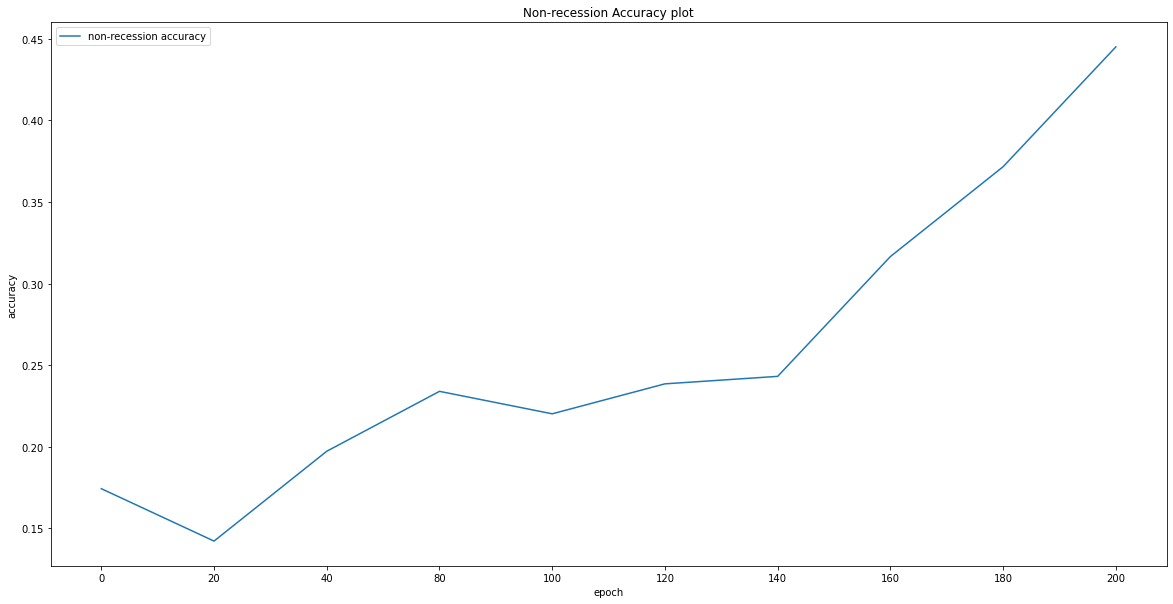

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

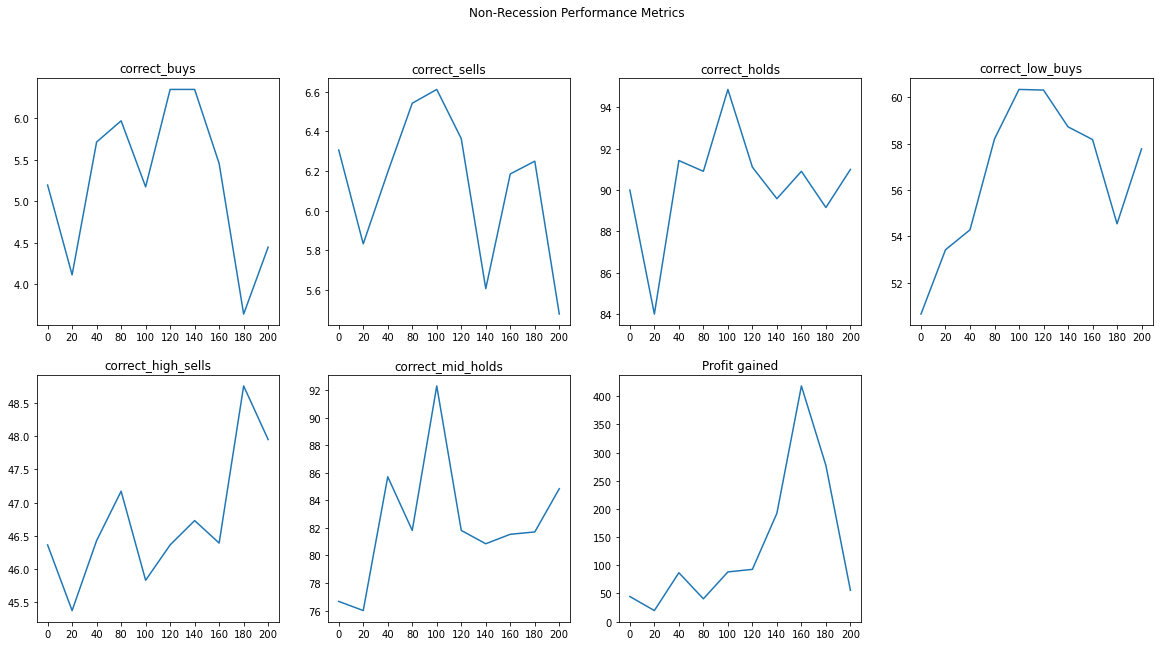

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

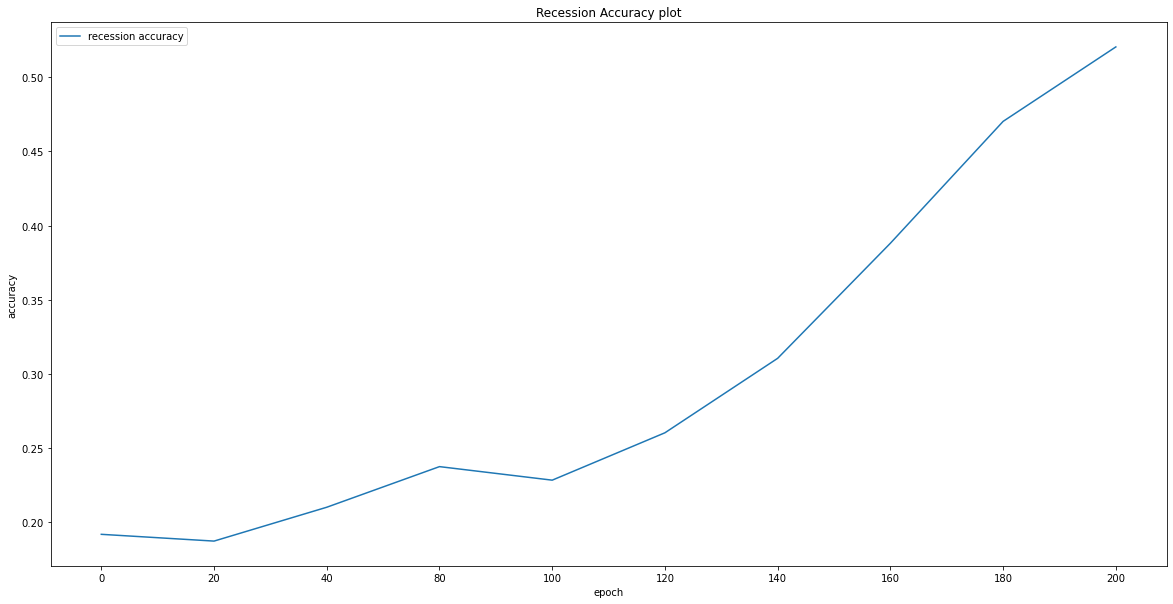

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(r_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

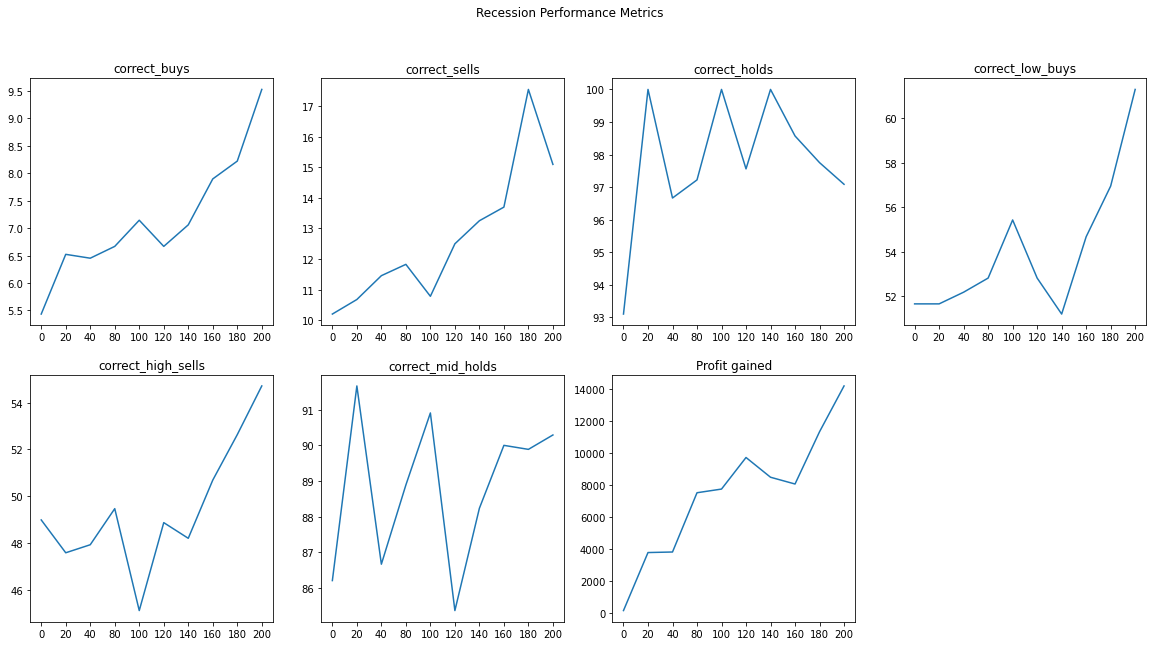

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

### Fresh Del Monte Produce Inc (small cap)

In [47]:
nr_test_sets = ['FDP']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_15 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1
    seq_new = []
    data_15 = []
    for i in range(0,len(sequential)):
        for j in range(0,len(sequential[i])):
            x = sequential[i][j]
            a = np.zeros(60)
            data_15.append(np.concatenate((x, a)))

        for j in range(1,50):
            x = np.zeros(64)
            data_15.append(x)
        seq_new.append(data_15)
        data_15 = []
        
    X = np.array(seq_new).reshape(-1, 64, 64, 1)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2019-01-22    30.219999  29.918096 -32.033467  1515700.0     2.0
2019-01-23    30.480000  30.004543 -24.791121  1646600.0     2.0
2019-01-24    30.459999  30.074613 -28.980936  1528300.0     2.0
2019-01-25    30.639999  30.161596 -35.265743  1632300.0     2.0
2019-01-28    30.879999  30.272119 -23.671560  1731100.0     2.0


In [48]:
r_test_sets = ['FDP']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_15 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1
    seq_new = []
    data_15 = []
    for i in range(0,len(sequential)):
        for j in range(0,len(sequential[i])):
            x = sequential[i][j]
            a = np.zeros(60)
            data_15.append(np.concatenate((x, a)))

        for j in range(1,50):
            x = np.zeros(64)
            data_15.append(x)
        seq_new.append(data_15)
        data_15 = []
        
    X = np.array(seq_new).reshape(-1, 64, 64, 1)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14     OBV_7  labels
Date                                                           
2020-01-22    34.250000  34.338683 -60.666656  -55800.0     2.0
2020-01-23    34.130001  34.306578 -67.360995 -191000.0     2.0
2020-01-24    34.520000  34.339413 -36.764689   18500.0     2.0
2020-01-27    32.290001  34.024118 -98.555924 -130500.0     2.0
2020-01-28    32.160000  33.737331 -85.885906 -280200.0     2.0


### Training Data

            previous_1d    EMA_12   willr_14     OBV_7  labels
Date                                                          
2000-01-21       8.7500  8.946622 -66.666667   78200.0     2.0
2000-01-24       8.8750  8.935603 -58.333333   99900.0     2.0
2000-01-25       9.0000  8.945511 -50.000000  123600.0     2.0
2000-01-26       8.6875  8.905817 -70.833333   87300.0     2.0
2000-01-27       8.5625  8.852999 -76.000000   32400.0     2.0


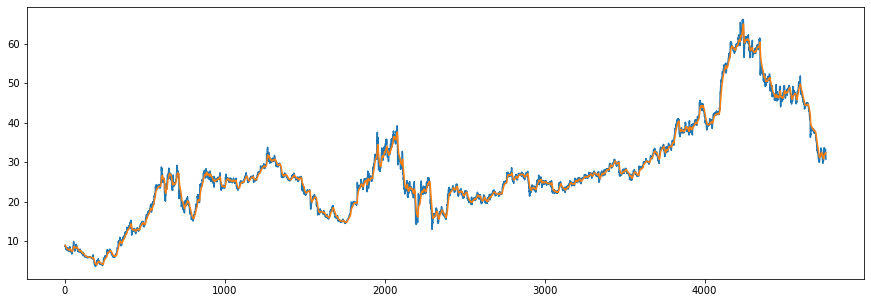

In [49]:
seed = 10
df = pd.read_csv('data/noncyclic_tickers/initial_indicators/FDP_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
seq_new = []
data_15 = []
for i in range(0,len(sequential)):
    for j in range(0,len(sequential[i])):
        x = sequential[i][j]
        a = np.zeros(60)
        data_15.append(np.concatenate((x, a)))
        
    for j in range(1,50):
        x = np.zeros(64)
        data_15.append(x)
    seq_new.append(data_15)
    data_15 = []
    
X = np.array(seq_new).reshape(-1, 64, 64, 1)
y = labels
y = np.array(y)

In [50]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [51]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [52]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [53]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [54]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('FDP')]
    y = nr_test_data['{}_y'.format('FDP')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format('FDP'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_non_recession.csv'.format(experiment,'FDP')):
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'FDP'))
    else:
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'FDP'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('FDP')]
    y = r_test_data['{}_y'.format('FDP')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test2.csv".format('FDP'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_recession.csv'.format(experiment,'FDP')):
        log.to_csv('{}_{}_recession.csv'.format(experiment,'FDP'))
    else:
        log.to_csv('{}_{}_recession.csv'.format(experiment,'FDP'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.272030651340996, 1: 7.1893939393939394, 2: 0.3671890114142}



RUNNING EPOCHS 0 - 20



Epoch 1/20
30/30 [==============================] - 1s 18ms/step - loss: 0.2184 - accuracy: 0.4884 - mse: 0.9599 - weighted_accuracy: 0.3215 - weighted_mse: 1.0217 - val_loss: 0.1826 - val_accuracy: 0.6080 - val_mse: 1.1302 - val_weighted_accuracy: 0.6080 - val_weighted_mse: 1.1302
Epoch 2/20
30/30 [==============================] - 0s 11ms/step - loss: 0.2047 - accuracy: 0.4694 - mse: 1.1496 - weighted_accuracy: 0.3671 - weighted_mse: 1.1873 - val_loss: 0.1849 - val_accuracy: 0.6006 - val_mse: 1.0437 - val_weighted_accuracy: 0.6006 - val_weighted_mse: 1.0437
Epoch 3/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1980 - accuracy: 0.4183 - mse: 1.1400 - weighted_accuracy: 0.4029 - weighted_mse: 1.1399 - val_loss: 0.1852 - val_accuracy: 0.4721 - val_mse: 1.0935 - val_weighted_accuracy: 0.4721 - val_weighted_mse: 1.0935
Epoch 4/20
30/30 [==============================] - 0s 12

0           5.320149  


Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.1945 - accuracy: 0.1918 - mse: 1.2757 - weighted_accuracy: 0.1918 - weighted_mse: 1.2757
Test loss: 0.19452597200870514
Test accuracy: 0.19178082048892975


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 2
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 8
actual sells but predicted hold: 0
actual holds but predicted buy: 78
actual holds but predicted sell: 95
actual predicted holds: 26
Percentage buys correct: 9.090909090909092%
Percentage sells correct: 7.619047619047619%
Percentage holds correct: 100.0%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 56.32183908045977%
Percentage high sells correct: 46.666666666666664%
Percentage mid holds correct: 92.3076923076923%


Capital: 100
Share price: $0.6128949931790368
Shares owned at the moment: 162
Cash capital at the momen

30/30 [==============================] - 0s 12ms/step - loss: 0.1750 - accuracy: 0.2013 - mse: 1.3760 - weighted_accuracy: 0.5421 - weighted_mse: 1.3182 - val_loss: 0.1982 - val_accuracy: 0.1675 - val_mse: 1.2587 - val_weighted_accuracy: 0.1675 - val_weighted_mse: 1.2587
Epoch 12/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1722 - accuracy: 0.2305 - mse: 1.3957 - weighted_accuracy: 0.5528 - weighted_mse: 1.3113 - val_loss: 0.2005 - val_accuracy: 0.1675 - val_mse: 1.3430 - val_weighted_accuracy: 0.1675 - val_weighted_mse: 1.3430
Epoch 13/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1731 - accuracy: 0.2160 - mse: 1.3870 - weighted_accuracy: 0.5348 - weighted_mse: 1.3036 - val_loss: 0.2019 - val_accuracy: 0.1538 - val_mse: 1.3032 - val_weighted_accuracy: 0.1538 - val_weighted_mse: 1.3032
Epoch 14/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1700 - accuracy: 0.2221 - mse: 1.4102 - weighted_accuracy: 0.5861 - weighted_mse: 1.

30/30 [==============================] - 0s 13ms/step - loss: 0.1695 - accuracy: 0.2284 - mse: 1.4610 - weighted_accuracy: 0.5703 - weighted_mse: 1.3635 - val_loss: 0.2033 - val_accuracy: 0.1644 - val_mse: 1.4088 - val_weighted_accuracy: 0.1644 - val_weighted_mse: 1.4088
Epoch 2/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1713 - accuracy: 0.1976 - mse: 1.4599 - weighted_accuracy: 0.5606 - weighted_mse: 1.3605 - val_loss: 0.1975 - val_accuracy: 0.1834 - val_mse: 1.3020 - val_weighted_accuracy: 0.1834 - val_weighted_mse: 1.3020
Epoch 3/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1695 - accuracy: 0.2226 - mse: 1.4060 - weighted_accuracy: 0.5788 - weighted_mse: 1.3285 - val_loss: 0.2014 - val_accuracy: 0.1728 - val_mse: 1.3671 - val_weighted_accuracy: 0.1728 - val_weighted_mse: 1.3671
Epoch 4/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1677 - accuracy: 0.2197 - mse: 1.4400 - weighted_accuracy: 0.5650 - weighted_mse: 1.360

7/7 [==============================] - 0s 3ms/step - loss: 0.1930 - accuracy: 0.2237 - mse: 1.4532 - weighted_accuracy: 0.2237 - weighted_mse: 1.4532
Test loss: 0.19302786886692047
Test accuracy: 0.22374428808689117


number of predictions: 219
actual predicted buys: 10
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 8
actual sells but predicted hold: 0
actual holds but predicted buy: 80
actual holds but predicted sell: 88
actual predicted holds: 31
Percentage buys correct: 10.869565217391305%
Percentage sells correct: 8.333333333333334%
Percentage holds correct: 100.0%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 56.043956043956044%
Percentage high sells correct: 48.958333333333336%
Percentage mid holds correct: 90.3225806451613%


Capital: 100
Share price: $0.6128949931790368
Shares owned at the moment: 162
Cash capital at the moment: $0.4379663855347644


Price increase

30/30 [==============================] - 0s 12ms/step - loss: 0.1623 - accuracy: 0.2381 - mse: 1.5211 - weighted_accuracy: 0.5954 - weighted_mse: 1.4249 - val_loss: 0.1998 - val_accuracy: 0.2181 - val_mse: 1.4581 - val_weighted_accuracy: 0.2181 - val_weighted_mse: 1.4581
Epoch 8/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1609 - accuracy: 0.2542 - mse: 1.4854 - weighted_accuracy: 0.6104 - weighted_mse: 1.4144 - val_loss: 0.1955 - val_accuracy: 0.2276 - val_mse: 1.4902 - val_weighted_accuracy: 0.2276 - val_weighted_mse: 1.4902
Epoch 9/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1624 - accuracy: 0.2503 - mse: 1.4925 - weighted_accuracy: 0.5981 - weighted_mse: 1.4167 - val_loss: 0.1980 - val_accuracy: 0.2129 - val_mse: 1.4688 - val_weighted_accuracy: 0.2129 - val_weighted_mse: 1.4688
Epoch 10/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1622 - accuracy: 0.2513 - mse: 1.5094 - weighted_accuracy: 0.5930 - weighted_mse: 1.41

7/7 [==============================] - 0s 3ms/step - loss: 0.1971 - accuracy: 0.2283 - mse: 1.5630 - weighted_accuracy: 0.2283 - weighted_mse: 1.5630
Test loss: 0.19707900285720825
Test accuracy: 0.2283104956150055


number of predictions: 219
actual predicted buys: 10
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 8
actual sells but predicted hold: 0
actual holds but predicted buy: 81
actual holds but predicted sell: 86
actual predicted holds: 32
Percentage buys correct: 10.75268817204301%
Percentage sells correct: 8.51063829787234%
Percentage holds correct: 100.0%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 56.52173913043478%
Percentage high sells correct: 48.93617021276596%
Percentage mid holds correct: 90.625%


Capital: 100
Share price: $0.6128949931790368
Shares owned at the moment: 162
Cash capital at the moment: $0.4379663855347644


Price increase from previousl

30/30 [==============================] - 0s 12ms/step - loss: 0.1562 - accuracy: 0.2476 - mse: 1.5973 - weighted_accuracy: 0.6261 - weighted_mse: 1.4929 - val_loss: 0.1981 - val_accuracy: 0.2434 - val_mse: 1.5535 - val_weighted_accuracy: 0.2434 - val_weighted_mse: 1.5535
Epoch 7/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1585 - accuracy: 0.2410 - mse: 1.6001 - weighted_accuracy: 0.6182 - weighted_mse: 1.5074 - val_loss: 0.2005 - val_accuracy: 0.2160 - val_mse: 1.4944 - val_weighted_accuracy: 0.2160 - val_weighted_mse: 1.4944
Epoch 8/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1554 - accuracy: 0.2339 - mse: 1.5802 - weighted_accuracy: 0.6138 - weighted_mse: 1.4844 - val_loss: 0.1972 - val_accuracy: 0.2434 - val_mse: 1.5318 - val_weighted_accuracy: 0.2434 - val_weighted_mse: 1.5318
Epoch 9/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1563 - accuracy: 0.2687 - mse: 1.5773 - weighted_accuracy: 0.6175 - weighted_mse: 1.490

7/7 [==============================] - 0s 3ms/step - loss: 0.1973 - accuracy: 0.2466 - mse: 1.5879 - weighted_accuracy: 0.2466 - weighted_mse: 1.5879
Test loss: 0.197309672832489
Test accuracy: 0.24657534062862396


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 1
actual holds but predicted buy: 67
actual holds but predicted sell: 94
actual predicted holds: 38
Percentage buys correct: 10.526315789473685%
Percentage sells correct: 7.8431372549019605%
Percentage holds correct: 92.6829268292683%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 60.0%
Percentage high sells correct: 50.98039215686274%
Percentage mid holds correct: 78.04878048780488%


Capital: 100
Share price: $0.6128949931790368
Shares owned at the moment: 162
Cash capital at the moment: $0.4379663855347644


Price increase from

30/30 [==============================] - 0s 12ms/step - loss: 0.1526 - accuracy: 0.2482 - mse: 1.6838 - weighted_accuracy: 0.6516 - weighted_mse: 1.5827 - val_loss: 0.2030 - val_accuracy: 0.2244 - val_mse: 1.5862 - val_weighted_accuracy: 0.2244 - val_weighted_mse: 1.5862
Epoch 8/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1506 - accuracy: 0.2621 - mse: 1.6612 - weighted_accuracy: 0.6314 - weighted_mse: 1.5838 - val_loss: 0.1981 - val_accuracy: 0.2508 - val_mse: 1.6093 - val_weighted_accuracy: 0.2508 - val_weighted_mse: 1.6093
Epoch 9/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1497 - accuracy: 0.3040 - mse: 1.6941 - weighted_accuracy: 0.6468 - weighted_mse: 1.5814 - val_loss: 0.1970 - val_accuracy: 0.2592 - val_mse: 1.6299 - val_weighted_accuracy: 0.2592 - val_weighted_mse: 1.6299
Epoch 10/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1477 - accuracy: 0.3011 - mse: 1.6876 - weighted_accuracy: 0.6511 - weighted_mse: 1.61

7/7 [==============================] - 0s 3ms/step - loss: 0.1991 - accuracy: 0.2785 - mse: 1.6612 - weighted_accuracy: 0.2785 - weighted_mse: 1.6612
Test loss: 0.1991071105003357
Test accuracy: 0.2785388231277466


number of predictions: 219
actual predicted buys: 9
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 1
actual holds but predicted buy: 76
actual holds but predicted sell: 79
actual predicted holds: 44
Percentage buys correct: 10.465116279069768%
Percentage sells correct: 9.195402298850574%
Percentage holds correct: 95.65217391304348%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 61.1764705882353%
Percentage high sells correct: 54.02298850574713%
Percentage mid holds correct: 78.26086956521739%


Capital: 100
Share price: $0.6128949931790368
Shares owned at the moment: 162
Cash capital at the moment: $0.4379663855347644


Price i

30/30 [==============================] - 0s 12ms/step - loss: 0.1459 - accuracy: 0.2940 - mse: 1.7328 - weighted_accuracy: 0.6685 - weighted_mse: 1.6365 - val_loss: 0.1988 - val_accuracy: 0.2645 - val_mse: 1.7260 - val_weighted_accuracy: 0.2645 - val_weighted_mse: 1.7260
Epoch 6/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1464 - accuracy: 0.2911 - mse: 1.7397 - weighted_accuracy: 0.6601 - weighted_mse: 1.6559 - val_loss: 0.2005 - val_accuracy: 0.2561 - val_mse: 1.6831 - val_weighted_accuracy: 0.2561 - val_weighted_mse: 1.6831
Epoch 7/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1453 - accuracy: 0.2782 - mse: 1.7635 - weighted_accuracy: 0.6681 - weighted_mse: 1.6890 - val_loss: 0.1986 - val_accuracy: 0.2719 - val_mse: 1.6800 - val_weighted_accuracy: 0.2719 - val_weighted_mse: 1.6800
Epoch 8/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1441 - accuracy: 0.3011 - mse: 1.7337 - weighted_accuracy: 0.6693 - weighted_mse: 1.674

7/7 [==============================] - 0s 3ms/step - loss: 0.1997 - accuracy: 0.2785 - mse: 1.7598 - weighted_accuracy: 0.2785 - weighted_mse: 1.7598
Test loss: 0.19971252977848053
Test accuracy: 0.2785388231277466


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 1
actual holds but predicted buy: 79
actual holds but predicted sell: 75
actual predicted holds: 45
Percentage buys correct: 9.090909090909092%
Percentage sells correct: 9.63855421686747%
Percentage holds correct: 93.75%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 58.62068965517241%
Percentage high sells correct: 55.42168674698795%
Percentage mid holds correct: 81.25%


Capital: 100
Share price: $0.6128949931790368
Shares owned at the moment: 162
Cash capital at the moment: $0.4379663855347644


Price increase from previously 

30/30 [==============================] - 0s 13ms/step - loss: 0.1386 - accuracy: 0.3177 - mse: 1.8598 - weighted_accuracy: 0.7043 - weighted_mse: 1.7870 - val_loss: 0.2046 - val_accuracy: 0.2729 - val_mse: 1.8622 - val_weighted_accuracy: 0.2729 - val_weighted_mse: 1.8622
Epoch 6/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1395 - accuracy: 0.3214 - mse: 1.8590 - weighted_accuracy: 0.6894 - weighted_mse: 1.7968 - val_loss: 0.1946 - val_accuracy: 0.3246 - val_mse: 1.8178 - val_weighted_accuracy: 0.3246 - val_weighted_mse: 1.8178
Epoch 7/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1400 - accuracy: 0.3145 - mse: 1.9089 - weighted_accuracy: 0.6796 - weighted_mse: 1.8731 - val_loss: 0.2050 - val_accuracy: 0.2677 - val_mse: 1.8335 - val_weighted_accuracy: 0.2677 - val_weighted_mse: 1.8335
Epoch 8/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1381 - accuracy: 0.3153 - mse: 1.8400 - weighted_accuracy: 0.6998 - weighted_mse: 1.819

7/7 [==============================] - 0s 3ms/step - loss: 0.1917 - accuracy: 0.3196 - mse: 1.8520 - weighted_accuracy: 0.3196 - weighted_mse: 1.8520
Test loss: 0.19173307716846466
Test accuracy: 0.31963470578193665


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 69
actual holds but predicted sell: 74
actual predicted holds: 56
Percentage buys correct: 9.090909090909092%
Percentage sells correct: 8.641975308641975%
Percentage holds correct: 91.80327868852459%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 56.578947368421055%
Percentage high sells correct: 54.32098765432099%
Percentage mid holds correct: 78.68852459016394%


Capital: 100
Share price: $0.6128949931790368
Shares owned at the moment: 162
Cash capital at the moment: $0.4379663855347644


Pric

30/30 [==============================] - 0s 12ms/step - loss: 0.1310 - accuracy: 0.3722 - mse: 2.1193 - weighted_accuracy: 0.7188 - weighted_mse: 2.1789 - val_loss: 0.1965 - val_accuracy: 0.3330 - val_mse: 1.9461 - val_weighted_accuracy: 0.3330 - val_weighted_mse: 1.9461
Epoch 8/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1345 - accuracy: 0.3828 - mse: 1.9857 - weighted_accuracy: 0.7210 - weighted_mse: 1.9797 - val_loss: 0.1962 - val_accuracy: 0.3319 - val_mse: 1.9268 - val_weighted_accuracy: 0.3319 - val_weighted_mse: 1.9268
Epoch 9/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1319 - accuracy: 0.3804 - mse: 2.0760 - weighted_accuracy: 0.7309 - weighted_mse: 2.0693 - val_loss: 0.1937 - val_accuracy: 0.3467 - val_mse: 2.0279 - val_weighted_accuracy: 0.3467 - val_weighted_mse: 2.0279
Epoch 10/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1315 - accuracy: 0.3791 - mse: 2.0340 - weighted_accuracy: 0.7287 - weighted_mse: 2.02

7/7 [==============================] - 0s 3ms/step - loss: 0.1888 - accuracy: 0.3607 - mse: 2.0336 - weighted_accuracy: 0.3607 - weighted_mse: 2.0336
Test loss: 0.18876522779464722
Test accuracy: 0.3607305884361267


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 0
actual predicted sells: 6
actual sells but predicted hold: 4
actual holds but predicted buy: 67
actual holds but predicted sell: 66
actual predicted holds: 66
Percentage buys correct: 9.45945945945946%
Percentage sells correct: 8.333333333333334%
Percentage holds correct: 90.41095890410959%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 57.534246575342465%
Percentage high sells correct: 52.77777777777778%
Percentage mid holds correct: 78.08219178082192%


Capital: 100
Share price: $0.6128949931790368
Shares owned at the moment: 162
Cash capital at the moment: $0.4379663855347644


Price 

30/30 [==============================] - 0s 12ms/step - loss: 0.1269 - accuracy: 0.4044 - mse: 2.2688 - weighted_accuracy: 0.7343 - weighted_mse: 2.3361 - val_loss: 0.1870 - val_accuracy: 0.3994 - val_mse: 2.2052 - val_weighted_accuracy: 0.3994 - val_weighted_mse: 2.2052
Epoch 12/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1254 - accuracy: 0.4442 - mse: 2.2508 - weighted_accuracy: 0.7489 - weighted_mse: 2.3486 - val_loss: 0.1967 - val_accuracy: 0.3593 - val_mse: 2.2071 - val_weighted_accuracy: 0.3593 - val_weighted_mse: 2.2071
Epoch 13/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1243 - accuracy: 0.4331 - mse: 2.2530 - weighted_accuracy: 0.7502 - weighted_mse: 2.3470 - val_loss: 0.2020 - val_accuracy: 0.3456 - val_mse: 2.2128 - val_weighted_accuracy: 0.3456 - val_weighted_mse: 2.2128
Epoch 14/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1229 - accuracy: 0.4476 - mse: 2.3138 - weighted_accuracy: 0.7628 - weighted_mse: 2.

7/7 [==============================] - 0s 3ms/step - loss: 0.1833 - accuracy: 0.4155 - mse: 2.1720 - weighted_accuracy: 0.4155 - weighted_mse: 2.1720
Test loss: 0.18332329392433167
Test accuracy: 0.4155251085758209


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 6
actual holds but predicted buy: 60
actual holds but predicted sell: 58
actual predicted holds: 81
Percentage buys correct: 9.090909090909092%
Percentage sells correct: 6.451612903225806%
Percentage holds correct: 89.01098901098901%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 58.46153846153846%
Percentage high sells correct: 51.61290322580645%
Percentage mid holds correct: 80.21978021978022%


Capital: 100
Share price: $0.6128949931790368
Shares owned at the moment: 162
Cash capital at the moment: $0.4379663855347644


Price 

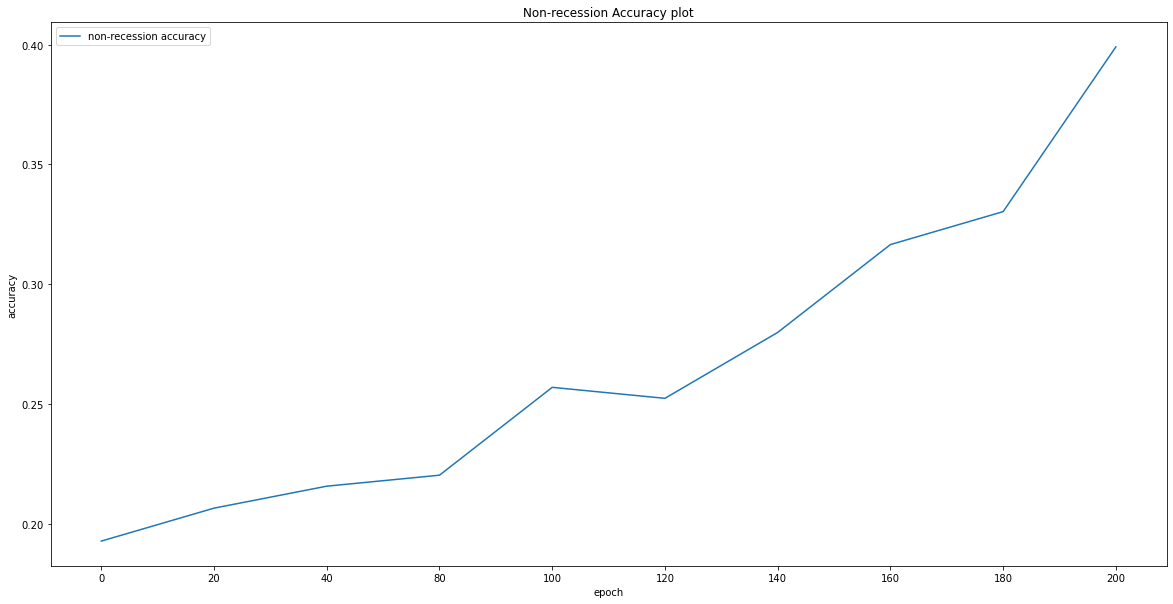

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

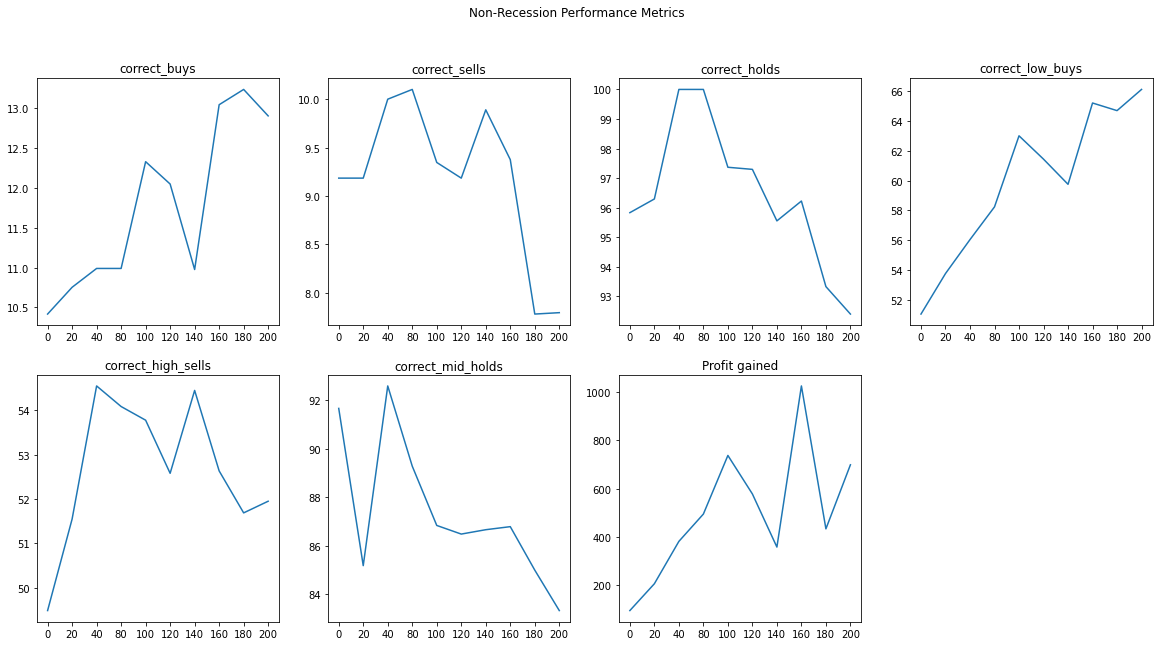

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

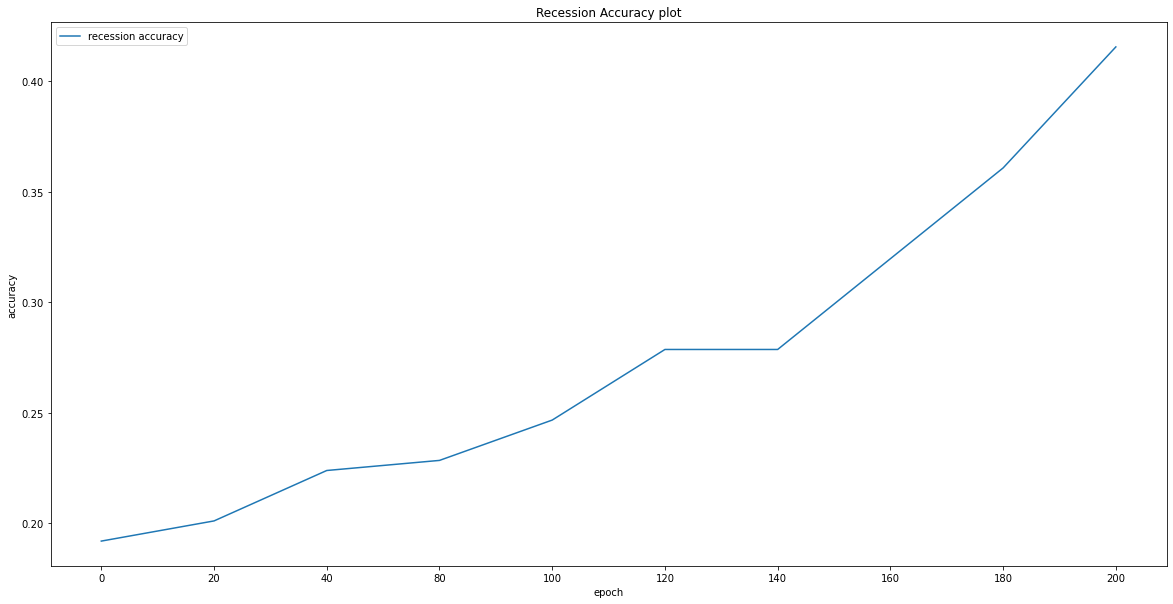

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(r_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

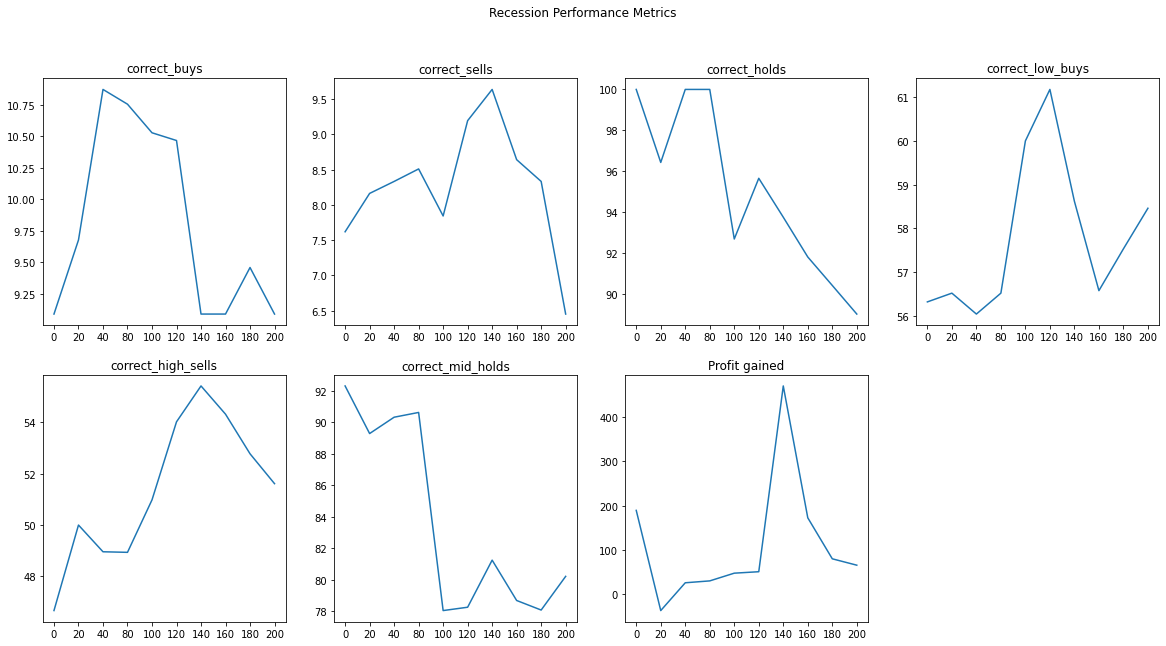

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")